# All approach 

Compare entry to every article in the database. 

In [1]:
import os
from pathlib import Path
import sys
node_type = os.getenv('BB_CPU')
venv_dir = f'/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-{node_type}'  # edit this line to match the venv directory format
venv_site_pkgs = Path(venv_dir) / 'lib' / f'python{sys.version_info.major}.{sys.version_info.minor}' / 'site-packages'
if venv_site_pkgs.exists():
    sys.path.insert(0, str(venv_site_pkgs))
else:
    print(f"Path '{venv_site_pkgs}' not found. Check that it exists and/or that it exists for node-type '{node_type}'.")

In [2]:
import pandas as pd

from torch.utils.data import Dataset, DataLoader

from Bio import Entrez

import random

import matplotlib.pyplot as plt 

import transformers

from sentence_transformers import SentenceTransformer, util, CrossEncoder

import torch

import torch.nn.functional as F

from torch.nn import DataParallel
from torch.utils.data import DataLoader, Dataset


from transformers import AutoTokenizer, AutoModel, TextClassificationPipeline, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM

from tqdm import tqdm

import time

import numpy as np

from dataclasses import dataclass

/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [3]:
%matplotlib inline 

## Collecting and proprecessing data 

In [4]:
with open("../data/all_articles.xml", mode="r") as file: 
    efetch_results = file.readlines() 

In [5]:
def extract_information(text, dictionary): 
    # first index always the id string
    split_text = text.split("\t")[1:]
    if len(split_text) == 2:
        dictionary["article_title"].append(split_text[0].strip("[]."))
        dictionary["article_abstract"].append(split_text[1])
        



In [6]:
all_articles_dict = {
    "article_title" : [], 
    "article_abstract" : [],
}
for entry in efetch_results:
    extract_information(entry, all_articles_dict)
    

In [7]:
all_articles_df = pd.DataFrame(all_articles_dict)


In [9]:
all_articles_df["article_text"] = all_articles_df["article_title"] + ". " + all_articles_df["article_abstract"]
all_articles_df

,article_title,article_abstract,article_text
0,Phospholipase A2 as a probe of phospholipid di...,The action of snake venom phospholipases A2 in...,Phospholipase A2 as a probe of phospholipid di...
1,Bile acids. XLVII. 12alpha-Hydroxylation of pr...,Rabbit liver microsomal preparations fortified...,Bile acids. XLVII. 12alpha-Hydroxylation of pr...
2,Spontaneous mortality and vascular lesions in ...,We have observed a high and significant mortal...,Spontaneous mortality and vascular lesions in ...
3,Peroxisome development in the metanephric kidn...,The relationship of enzymatic activity to orga...,Peroxisome development in the metanephric kidn...
4,Effect on aging on plasma renin and aldosteron...,The influence of aging on the renin-angiotensi...,Effect on aging on plasma renin and aldosteron...
...,...,...,...
56340,High endogenous calcium buffering in Purkinje ...,1. The ability of Purkinje cells to rapidly bu...,High endogenous calcium buffering in Purkinje ...
56341,Combined dexamethasone/CRH test in rats: hypot...,Alterations of the hypothalamo-pituitary-adren...,Combined dexamethasone/CRH test in rats: hypot...
56342,Hypophysiotropic somatostatin expression durin...,Based on previous findings that the inhibitory...,Hypophysiotropic somatostatin expression durin...
56343,Growth-associated protein (GAP-43) in terminal...,Growth-associated protein (GAP-43) immunoreact...,Growth-associated protein (GAP-43) in terminal...


In [23]:
open_problems = pd.read_csv("../data/selected-open-problems1.csv", skiprows=1)
open_problems.head()

,Titles,Scores
0,Which changes in model organisms associated wi...,4
1,Can we come up with better markers that repres...,4
2,Which cellular changes that contribute to agei...,4
3,Are there are specific tissues or cell types t...,4
4,Can we apply stem cell therapy based on our ow...,4


In [24]:
open_problem_embeddings = open_problems.loc[:, ["Titles"]].rename(columns={"Titles": "open_problem_title"})
open_problem_embeddings

,open_problem_title
0,Which changes in model organisms associated wi...
1,Can we come up with better markers that repres...
2,Which cellular changes that contribute to agei...
3,Are there are specific tissues or cell types t...
4,Can we apply stem cell therapy based on our ow...
...,...
180,Are there current or prospective synthetic met...
181,Is it feasible to achieve targeted delivery of...
182,Are there compounds known to alleviate both pr...
183,Are there established methodologies capable of...


# Semantic search first - Preselection  

**Note**: The embeddings were calculated using a HPC script.

In [4]:
open_problem_embeddings_df = pd.read_parquet("../data/similarity_scores/open_problem_embeddings.parquet")
article_embeddings_df = pd.read_parquet("../data/similarity_scores/article_embeddings.parquet")

In [5]:
article_embeddings_df

,article_title,article_abstract,article_text,embedding
0,Phospholipase A2 as a probe of phospholipid di...,The action of snake venom phospholipases A2 in...,Phospholipase A2 as a probe of phospholipid di...,"[0.03324238583445549, -0.10877010226249695, -0..."
1,Bile acids. XLVII. 12alpha-Hydroxylation of pr...,Rabbit liver microsomal preparations fortified...,Bile acids. XLVII. 12alpha-Hydroxylation of pr...,"[0.31813573837280273, 0.10684096068143845, -0...."
2,Spontaneous mortality and vascular lesions in ...,We have observed a high and significant mortal...,Spontaneous mortality and vascular lesions in ...,"[0.6937615871429443, -0.07225436717271805, 0.1..."
3,Peroxisome development in the metanephric kidn...,The relationship of enzymatic activity to orga...,Peroxisome development in the metanephric kidn...,"[0.103456512093544, 0.09430592507123947, 0.160..."
4,Effect on aging on plasma renin and aldosteron...,The influence of aging on the renin-angiotensi...,Effect on aging on plasma renin and aldosteron...,"[0.09751694649457932, -0.017173567786812782, -..."
...,...,...,...,...
200223,Filbertone Reduces Senescence in C2C12 Myotube...,"It has been demonstrated that filbertone, the ...",Filbertone Reduces Senescence in C2C12 Myotube...,"[0.060570452362298965, 0.03348590433597565, 0...."
200224,Balancing the Oral-Gut-Brain Axis with Diet,Background: The oral microbiota is the second ...,Balancing the Oral-Gut-Brain Axis with Diet. B...,"[0.2994225323200226, -0.16133029758930206, 0.9..."
200225,"Piperine, a black pepper compound, induces aut...",Acute leukemia is characterized by abnormal wh...,"Piperine, a black pepper compound, induces aut...","[-0.20277704298496246, -0.70625901222229, -0.0..."
200226,Alterations of senescence-associated markers i...,Non-syndromic cleft lip with or without cleft ...,Alterations of senescence-associated markers i...,"[0.4387986660003662, -0.17013613879680634, 0.2..."


In [22]:
open_problem_embeddings = np.vstack(open_problem_embeddings_df['embedding'].values)
article_embeddings = np.vstack(article_embeddings_df['embedding'].values)
similarity_scores = util.cos_sim(open_problem_embeddings, article_embeddings)
open_problem_titles = np.repeat(open_problem_embeddings_df['open_problem_title'].values, len(article_embeddings))
article_titles = np.tile(article_embeddings_df['article_title'].values, len(open_problem_embeddings))
similarity_scores_flat = similarity_scores.numpy().flatten()
open_problem_titles = np.repeat(open_problem_embeddings_df['open_problem_title'].values, len(article_embeddings))
article_titles = np.tile(article_embeddings_df['article_title'].values, len(open_problem_embeddings))
similarity_scores_flat = similarity_scores.numpy().flatten()

In [25]:
# Create a DataFrame in long format
long_similarity_df = pd.DataFrame({
    'open_problem_title': open_problem_titles,
    'article_title': article_titles,
    'similarity_score': similarity_scores_flat
})

long_similarity_df.to_parquet("../data/similarity_scores/all_approach/all_similarity_scores.parquet")

**The similarity score file has been created so do not run the above code**

In [26]:
similarity_scores_df = pd.read_parquet("../data/similarity_scores/all_approach/all_similarity_scores.parquet")

In [27]:
pd.set_option('display.max_colwidth', None)
similarity_scores_df

,open_problem_title,article_title,similarity_score
0,Which changes in model organisms associated with ageing also change in a similar way in humans?,Phospholipase A2 as a probe of phospholipid distribution in erythrocyte membranes. Factors influencing the apparent specificity of the reaction,-0.059255
1,Which changes in model organisms associated with ageing also change in a similar way in humans?,Bile acids. XLVII. 12alpha-Hydroxylation of precursors of allo bile acids by rabbit liver microsomes,-0.079126
2,Which changes in model organisms associated with ageing also change in a similar way in humans?,Spontaneous mortality and vascular lesions in 3 rat strains with different blood pressure levels,0.143367
3,Which changes in model organisms associated with ageing also change in a similar way in humans?,Peroxisome development in the metanephric kidney of mouse,0.106619
4,Which changes in model organisms associated with ageing also change in a similar way in humans?,Effect on aging on plasma renin and aldosterone in normal man,0.147719
...,...,...,...
40245823,Can a drug slow human aging?,Filbertone Reduces Senescence in C2C12 Myotubes Treated with Doxorubicin or H2O2 through MuRF1 and Myogenin,0.200813
40245824,Can a drug slow human aging?,Balancing the Oral-Gut-Brain Axis with Diet,0.097220
40245825,Can a drug slow human aging?,"Piperine, a black pepper compound, induces autophagy and cellular senescence mediated by NF-κB and IL-6 in acute leukemia",0.005315
40245826,Can a drug slow human aging?,Alterations of senescence-associated markers in patients with non-syndromic cleft lip and palate,-0.049806


## Plot distribution 

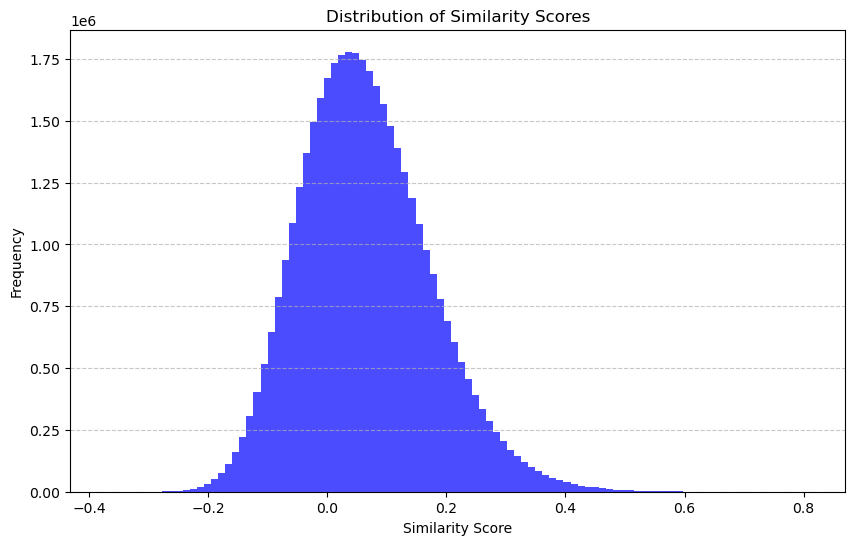

In [28]:
# Plot the distribution of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(similarity_scores_df['similarity_score'], bins=100, color='blue', alpha=0.7)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot to a file if needed
plt.savefig('../data/figures/all_approach/similarity_score_distribution.png', dpi=300)

In [29]:
similarity_scores_df["similarity_score"].describe()

count    4.024583e+07
mean     6.441663e-02
std      1.088116e-01
min     -3.721195e-01
25%     -1.284068e-02
50%      5.588482e-02
75%      1.324219e-01
max      8.107153e-01
Name: similarity_score, dtype: float64

In [30]:
upper_quartile_scores_df = similarity_scores_df[similarity_scores_df["similarity_score"] >= 0.2]
merged_df = upper_quartile_scores_df.merge(
    article_embeddings_df[['article_title', 'article_abstract']], 
    on='article_title', 
    how='left'
)


In [31]:
merged_df = merged_df.loc[:,["open_problem_title", "article_title", "article_abstract", "similarity_score"]]
merged_df.to_parquet("../data/similarity_scores/all_approach/upper_quartile_scores.parquet")

In [32]:
merged_df

,open_problem_title,article_title,article_abstract,similarity_score
0,Which changes in model organisms associated with ageing also change in a similar way in humans?,"The late effects of selected immunosuppressants on immunocompetence, disease incidence, and mean life-span. II. Cell-mediated immune activity","The late effects of various immunosuppressive insults on cell-mediated immunity in mice were studied in an attempt to assess the role of immune surveillance in the aging process. Results were obtained using susceptibility to allogeneic tumor cell challenge, graft-versus-host reaction (GVHR), blastogenic response to PHA, a thymus derived T cell-specific plant mitogen, and cytolytic activity against allogeneic tumor cells as measures of immunologic activity. In vivo studies late in life show that resistance to allogeneic tumor cells is significantly decreased in thymectomized mice, whereas those treated with cortisone, cyclophosphamide and sublethal X-ray remain unchanged. Spleen cells from only the thymectomized and the sublethally irradiated mice show reduced activity in the GVHR. No difference is seen in the activity of bone marrow cells. Results consistent with these findings were obtained in in vitro studies. Thus spleen cells from thymectomized or sublethally irradiated mice show decreased activity is response to PHA, whereas no change is seen in spleen cells from other treated groups. Hence, surgical and physical insults are more likely to induce long-lasting immunosuppression in those immunocompetent tissues whose activity normally diminishes with advancing age. Furthermore, the degree of immunosuppression seen in this study is not of the order of magnitude that one could reasonably predict a significant decrease in mean life-span.\n",0.208080
1,Which changes in model organisms associated with ageing also change in a similar way in humans?,The regulation of physiological changes during mammalian aging,"Much evidence suggests that intrinsic molecular or cellular aging mechanisms need not be invoked to explain most age-related cellular changes and pathologcical conditions. Analysis of a widely scattered literature indicates that hormones and neural factors regulate a great number of cellular aging phenomena of mammals. It is proposed that age-related changes after maturation result from an extension of the neural and endocrine mechanisms that control earlier development and that produce a regulatory cascade of changing neural, endocrine, and target-tissue interactions.\n",0.518936
2,Which changes in model organisms associated with ageing also change in a similar way in humans?,An exploratory investigation of the personality correlates of aging using the Hand Test,"The Hand Test was administered to 27 older adults of both sexes (Mage = 66.56) to investigate possible changes in personality concomitant with normal aging. To control partially for such factors as cultural influences and intelligence differences a matched-pair design was used in which the test protocols of the older adults were matched with those of their children of the same sex (Mage = 36.44). Though the Hand Test has not been independently validated on older adults, results were consistent with past findings using projective techniques inasmuch as depletion and constriction of personality were noted. Criticisms of research on the clinical assessment of the elderly were discussed.\n",0.227924
3,Which changes in model organisms associated with ageing also change in a similar way in humans?,Cellular immunity against bacteria (intracellular and extracellular parasites) in experimentally aged rats (author's transl),"The authors study the activity of RES in rats with Progeria-like syndrome of Selye, at the occasion of a repeated infection with bacteria--intracellular parasites (Brucella abortus 19) and bacteria--extracellular parasites (Diplococcus pneumoniae). They establish that immunization improves the activity of RES of the experimentally aged rats; still

In [33]:
pd.reset_option('display.max_colwidth')

# MED-CPT Cross Encoder 

**BELOW CODE IS FOR REFERENCE AND WILL BE RUN BY HPC**

In [4]:
tokenizer = AutoTokenizer.from_pretrained("ncbi/MedCPT-Cross-Encoder")
model = AutoModelForSequenceClassification.from_pretrained("ncbi/MedCPT-Cross-Encoder")

/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

In [5]:
# Use DataParallel to distribute across multiple GPUs
model = DataParallel(model)
model.to('cuda')
model.eval()  


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

In [73]:
# We only need the article_text here as we will re-compute scores. 
similarity_scores_df = pd.read_parquet("../data/similarity_scores/all_approach/upper_quartile_scores.parquet")
problem_article_pairs_df = similarity_scores_df.loc[:, ["open_problem_title", "article_title", "article_abstract"]]

In [74]:
problem_article_pairs_df["article_text"] = problem_article_pairs_df["article_title"] + ". " + problem_article_pairs_df["article_abstract"]

In [75]:
def compute_scores_in_batch(row):
    title = row["open_problem_title"]
    article_text = row["article_text"]
    pair = [title, article_text]
    
    with torch.no_grad():
        encoded = tokenizer(
            pair,
            truncation=True,
            padding=True,
            return_tensors='pt',
            max_length=512
        ).to('cuda')
        
        logits = model(**encoded).logits
        score = logits[0].cpu().item()  # Move to CPU and get the first item as a scalar
    
    return score



In [ ]:
tqdm.pandas()  
problem_article_pairs_df["score"] = problem_article_pairs_df.progress_apply(compute_scores_in_batch, axis=1) 

In [ ]:
problem_article_pairs.to_parquet("../data/similarity_scores/all_approach/cross_encoder_scores.parquet")

**Above calculation is for reference and will be calculated via HPC script instead**

In [36]:
cross_encoder_scores_df = pd.read_parquet("../data/similarity_scores/all_approach/cross_encoder_scores.parquet")

In [37]:
cross_encoder_scores_df

,open_problem_title,article_title,article_abstract,article_text,score
0,Which changes in model organisms associated with ageing also change in a similar way in humans?,"The late effects of selected immunosuppressants on immunocompetence, disease incidence, and mean life-span. II. Cell-mediated immune activity","The late effects of various immunosuppressive insults on cell-mediated immunity in mice were studied in an attempt to assess the role of immune surveillance in the aging process. Results were obtained using susceptibility to allogeneic tumor cell challenge, graft-versus-host reaction (GVHR), blastogenic response to PHA, a thymus derived T cell-specific plant mitogen, and cytolytic activity against allogeneic tumor cells as measures of immunologic activity. In vivo studies late in life show that resistance to allogeneic tumor cells is significantly decreased in thymectomized mice, whereas those treated with cortisone, cyclophosphamide and sublethal X-ray remain unchanged. Spleen cells from only the thymectomized and the sublethally irradiated mice show reduced activity in the GVHR. No difference is seen in the activity of bone marrow cells. Results consistent with these findings were obtained in in vitro studies. Thus spleen cells from thymectomized or sublethally irradiated mice show decreased activity is response to PHA, whereas no change is seen in spleen cells from other treated groups. Hence, surgical and physical insults are more likely to induce long-lasting immunosuppression in those immunocompetent tissues whose activity normally diminishes with advancing age. Furthermore, the degree of immunosuppression seen in this study is not of the order of magnitude that one could reasonably predict a significant decrease in mean life-span.\n","The late effects of selected immunosuppressants on immunocompetence, disease incidence, and mean life-span. II. Cell-mediated immune activity. The late effects of various immunosuppressive insults on cell-mediated immunity in mice were studied in an attempt to assess the role of immune surveillance in the aging process. Results were obtained using susceptibility to allogeneic tumor cell challenge, graft-versus-host reaction (GVHR), blastogenic response to PHA, a thymus derived T cell-specific plant mitogen, and cytolytic activity against allogeneic tumor cells as measures of immunologic activity. In vivo studies late in life show that resistance to allogeneic tumor cells is significantly decreased in thymectomized mice, whereas those treated with cortisone, cyclophosphamide and sublethal X-ray remain unchanged. Spleen cells from only the thymectomized and the sublethally irradiated mice show reduced activity in the GVHR. No difference is seen in the activity of bone marrow cells. Results consistent with these findings were obtained in in vitro studies. Thus spleen cells from thymectomized or sublethally irradiated mice show decreased activity is response to PHA, whereas no change is seen in spleen cells from other treated groups. Hence, surgical and physical insults are more likely to induce long-lasting immunosuppression in those immunocompetent tissues whose activity normally diminishes with advancing age. Furthermore, the degree of immunosuppression seen in this study is not of the order of magnitude that one could reasonably predict a significant decrease in mean life-span.\n",-10.411860
1,Which changes in model organisms associated with ageing also change in a similar way in humans?,The regulation of physiological changes during mammalian aging,"Much evidence suggests that intrinsic molecular or cellular aging mechanisms need not be invoked to explain most age-related cellular changes and pathologcical conditions. Analysis of a widely scattered literature indicates that hormones and neural factors regulate a great number of cellular aging phenomena of mammals. It is proposed that age-related changes after maturation result from an extension of the neural and endocrine mechanism

In [54]:
# Convert to probability 
# Function to convert logits to probabilities using sigmoid
def logit_to_probability(logit):
    return torch.sigmoid(torch.tensor(logit)).item()

# Apply the sigmoid function to the 'score' column to get probabilities
cross_encoder_scores_df['probability'] = cross_encoder_scores_df['score'].apply(logit_to_probability)


NameError: name 'cross_encoder_scores_df' is not defined

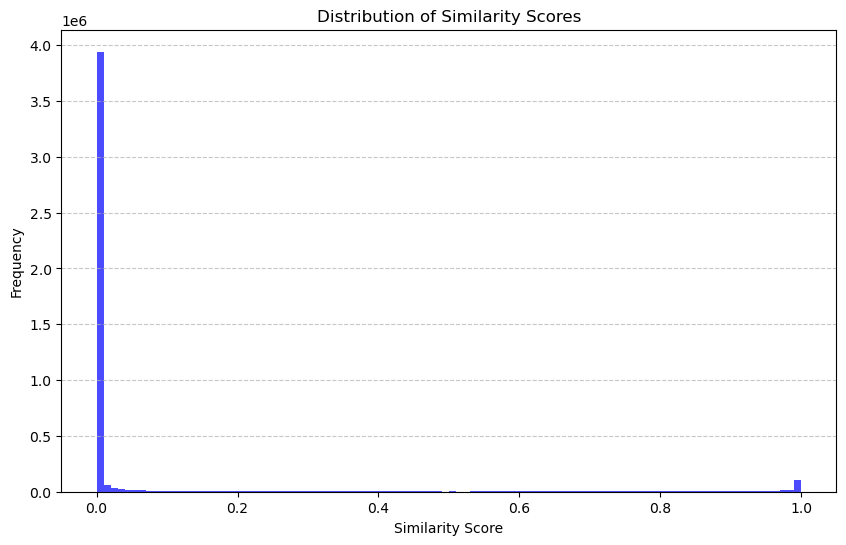

In [39]:
# Plot the distribution of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(cross_encoder_scores_df['probability'], bins=100, color='blue', alpha=0.7)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot to a file if needed
plt.savefig('../data/figures/all_approach/cross_encoder_score_distribution.png', dpi=300)

In [40]:
cross_encoder_scores_df["probability"].describe()

count    4.544255e+06
mean     6.316530e-02
std      2.181219e-01
min      1.091384e-07
25%      2.566576e-07
50%      3.353329e-06
75%      1.999033e-04
max      9.999999e-01
Name: probability, dtype: float64

## 0.2 threshold 

In [41]:
threshold_02_df = cross_encoder_scores_df[cross_encoder_scores_df["probability"] >= 0.2]
threshold_02_df

,open_problem_title,article_title,article_abstract,article_text,score,probability
1,Which changes in model organisms associated with ageing also change in a similar way in humans?,The regulation of physiological changes during mammalian aging,"Much evidence suggests that intrinsic molecular or cellular aging mechanisms need not be invoked to explain most age-related cellular changes and pathologcical conditions. Analysis of a widely scattered literature indicates that hormones and neural factors regulate a great number of cellular aging phenomena of mammals. It is proposed that age-related changes after maturation result from an extension of the neural and endocrine mechanisms that control earlier development and that produce a regulatory cascade of changing neural, endocrine, and target-tissue interactions.\n","The regulation of physiological changes during mammalian aging. Much evidence suggests that intrinsic molecular or cellular aging mechanisms need not be invoked to explain most age-related cellular changes and pathologcical conditions. Analysis of a widely scattered literature indicates that hormones and neural factors regulate a great number of cellular aging phenomena of mammals. It is proposed that age-related changes after maturation result from an extension of the neural and endocrine mechanisms that control earlier development and that produce a regulatory cascade of changing neural, endocrine, and target-tissue interactions.\n",7.106737,0.999181
8,Which changes in model organisms associated with ageing also change in a similar way in humans?,Genetic aspects of aging (author's transl),"The experimental results indicating a primary genetic cause of aging and some diseases of the old age (cancer, arteriosclerosis, immune deficiency, autoimmune diseases) are summarized under two aspects: 1) The genetic influence is determined during the differentiation and development phase of the organism, whereby the direct or indirect (pleiotropic effect) selection of genes of aging, or the missing selection of genes which are acting against aging come into consideration. 2) The dicisive gene alterations take place by spontaneous and/or induced somatic mutations.\n","Genetic aspects of aging (author's transl). The experimental results indicating a primary genetic cause of aging and some diseases of the old age (cancer, arteriosclerosis, immune deficiency, autoimmune diseases) are summarized under two aspects: 1) The genetic influence is determined during the differentiation and development phase of the organism, whereby the direct or indirect (pleiotropic effect) selection of genes of aging, or the missing selection of genes which are acting against aging come into consideration. 2) The dicisive gene alterations take place by spontaneous and/or induced somatic mutations.\n",-1.269557,0.219333
13,Which changes in model organisms associated with ageing also change in a similar way in humans?,Model systems for studies on cellular basis of organ ageing,"The cellular basis of the age-related decline in the functional capacity of many mammalian organs is still poorly understood. In this paper, the rat liver is presented as a promising model for studying cellular phenomena underlying organ ageing. The recent development of methods for isolation and purification of parenchymal, Kupffer and endothelial cells from the rat liver makes possible the comparison of functional and metabolic changes in the intact liver with changes in distinct liver cell classes isolated from rats of various age groups. An attempt has been made to correlate age changes in some important liver-specific functions, such as bromsulophthalein uptake and albumin synthesis, at the organ and at the cellular level. To compare cellular ageing phenomena in long-lived cells (parenchymal cells) and short lived cells (Kupffer and endothelial cells) from the same organ, the role of lysosomes in cellular ageing processes was investigated, with secial reference to the functioning

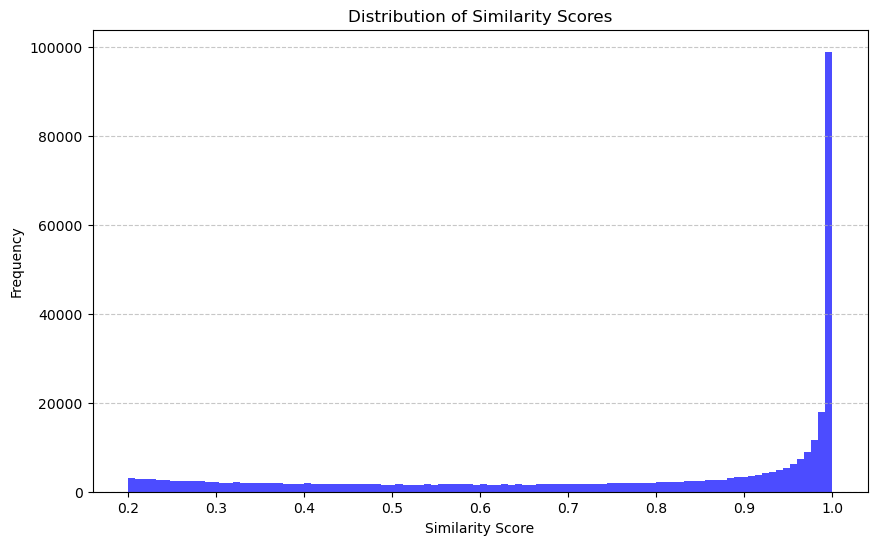

In [42]:
# Plot the distribution of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(threshold_02_df['probability'], bins=100, color='blue', alpha=0.7)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot to a file if needed
# plt.savefig('../data/figures/all_approach/cross_encoder_score_distribution.png', dpi=300)

In [43]:
pd.set_option('display.max_colwidth', None)

threshold_02_df.loc[:,["open_problem_title", "article_text", "probability"]].tail(20)

,open_problem_title,article_text,probability
4544133,Can a drug slow human aging?,"Targeting multiple hallmarks of mammalian aging with combinations of interventions. Aging is currently viewed as a result of multiple biological processes that manifest themselves independently, reinforce each other and in their totality lead to the aged phenotype. Genetic and pharmaceutical approaches targeting specific underlying causes of aging have been used to extend the lifespan and healthspan of model organisms ranging from yeast to mammals. However, most interventions display only a modest benefit. This outcome is to be expected if we consider that even if one aging process is successfully treated, other aging pathways may remain intact. Hence solving the problem of aging may require targeting not one but many of its underlying causes at once. Here we review the challenges and successes of combination therapies aimed at increasing the lifespan of mammals and propose novel directions for their development. We conclude that both additive and synergistic effects on mammalian lifespan can be achieved by combining interventions that target the same or different hallmarks of aging. However, the number of studies in which multiple hallmarks were targeted simultaneously is surprisingly limited. We argue that this approach is as promising as it is understudied.\n",0.999983
4544135,Can a drug slow human aging?,"The influential responsibility of sirtuins in senescence and associated diseases: A review. Aging is a process of time-associated depletion in the physiological functions, essential for the survival and reproducibility of living beings. Some age-related disorders can be successfully controlled with some biomedical techniques or pharmaceutical approaches. There are some precise remedies that demonstrate conspicuous promise in the preclinical and clinical setup of extending lifespan or enhancing health by altering natural senescence. The sirtuin family of proteins is one of the most favorable targets for antiaging strategies. Sirtuins were initially identified as transcription repressors in yeast, but today they are known to exist in bacteria and eukaryotes, as well as humans. The SIRT (1-7) family of proteins in humans is made up of seven members, each of which has either mono-ADP ribosyl transferase or deacetylase activity. Researchers suggest that sirtuins are essential for cell metabolism and play a major role in how cells react to various stimuli, such as oxidative or genotoxic stress. A healthy lifestyle, which includes exercise and a balanced diet, has been demonstrated to impact health span by adjusting the levels of sirtuins, suggesting the involvement of sirtuins in extending human longevity. The hunt for sirtuin activators is among the most extensive and comprehensive research subjects in the present scenario. Some optimism has been generated to investigate antiaging therapies by natural compounds, such as curcumin and others. This review article highlights the role of sirtuins in native senescence and their primordial roles in the progression of several life-threatening diseases. Further, it also provides recent information on the sirtuin activators and inhibitors and their therapeutic benefits.\n",0.981738
4544152,Can a drug slow human aging?,"Analyzing parametric influences driving age-associated changes in absorption using a PBPK-GSA approach. The advanced age population may be susceptible to an increased risk of adverse effects due to increased drug exposure after oral dosing. Factors such as high-interindividual variability and lack of data has led to poor characterization of absorption's role in pharmacokinetic changes in this population. Physiologically based pharmacokinetic (PBPK) models are increasingly being used during the drug development process, as their unique qualities are advantageous in atypical scenarios such as drug-drug interactions or special populations such as older people. Along with relying on various sou

### Threshold of 0.5 and above

In [44]:
threshold_05_df = cross_encoder_scores_df[cross_encoder_scores_df["probability"] >= 0.5]
threshold_05_df

,open_problem_title,article_title,article_abstract,article_text,score,probability
1,Which changes in model organisms associated with ageing also change in a similar way in humans?,The regulation of physiological changes during mammalian aging,"Much evidence suggests that intrinsic molecular or cellular aging mechanisms need not be invoked to explain most age-related cellular changes and pathologcical conditions. Analysis of a widely scattered literature indicates that hormones and neural factors regulate a great number of cellular aging phenomena of mammals. It is proposed that age-related changes after maturation result from an extension of the neural and endocrine mechanisms that control earlier development and that produce a regulatory cascade of changing neural, endocrine, and target-tissue interactions.\n","The regulation of physiological changes during mammalian aging. Much evidence suggests that intrinsic molecular or cellular aging mechanisms need not be invoked to explain most age-related cellular changes and pathologcical conditions. Analysis of a widely scattered literature indicates that hormones and neural factors regulate a great number of cellular aging phenomena of mammals. It is proposed that age-related changes after maturation result from an extension of the neural and endocrine mechanisms that control earlier development and that produce a regulatory cascade of changing neural, endocrine, and target-tissue interactions.\n",7.106737,0.999181
13,Which changes in model organisms associated with ageing also change in a similar way in humans?,Model systems for studies on cellular basis of organ ageing,"The cellular basis of the age-related decline in the functional capacity of many mammalian organs is still poorly understood. In this paper, the rat liver is presented as a promising model for studying cellular phenomena underlying organ ageing. The recent development of methods for isolation and purification of parenchymal, Kupffer and endothelial cells from the rat liver makes possible the comparison of functional and metabolic changes in the intact liver with changes in distinct liver cell classes isolated from rats of various age groups. An attempt has been made to correlate age changes in some important liver-specific functions, such as bromsulophthalein uptake and albumin synthesis, at the organ and at the cellular level. To compare cellular ageing phenomena in long-lived cells (parenchymal cells) and short lived cells (Kupffer and endothelial cells) from the same organ, the role of lysosomes in cellular ageing processes was investigated, with secial reference to the functioning of the lysosomal enzyme cathepsin D. The specific cathepsin D activity in Kupffer cells was abour 3 times higher than in endothelial cells and about 20 times higher than in parenchymal cells. The enzyme activity in the latter cell type showed a significant increase with age.\n","Model systems for studies on cellular basis of organ ageing. The cellular basis of the age-related decline in the functional capacity of many mammalian organs is still poorly understood. In this paper, the rat liver is presented as a promising model for studying cellular phenomena underlying organ ageing. The recent development of methods for isolation and purification of parenchymal, Kupffer and endothelial cells from the rat liver makes possible the comparison of functional and metabolic changes in the intact liver with changes in distinct liver cell classes isolated from rats of various age groups. An attempt has been made to correlate age changes in some important liver-specific functions, such as bromsulophthalein uptake and albumin synthesis, at the organ and at the cellular level. To compare cellular ageing phenomena in long-lived cells (parenchymal cells) and short lived cells (Kupffer and endothelial cells) from the same organ, the role of lysosomes in cellular ageing processes was investigated, with secial reference to the functioning of the lysosom

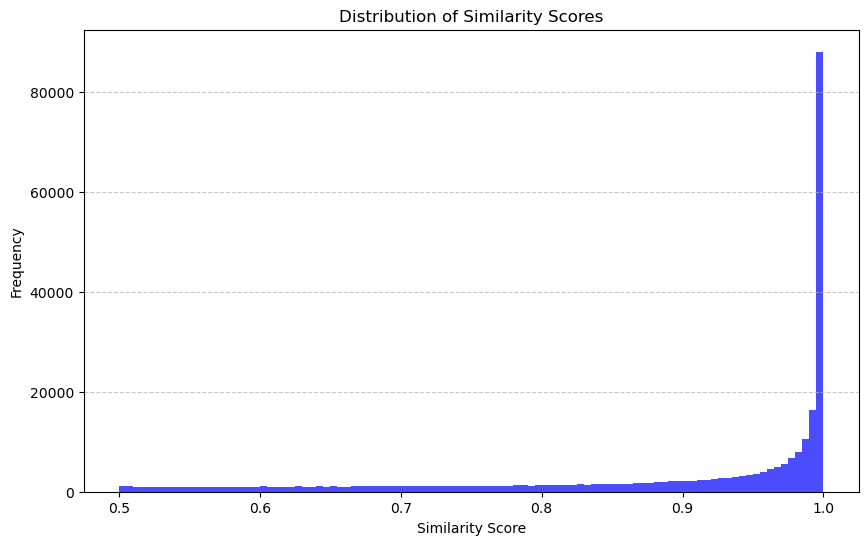

In [45]:
# Plot the distribution of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(threshold_05_df['probability'], bins=100, color='blue', alpha=0.7)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot to a file if needed
# plt.savefig('../data/figures/all_approach/cross_encoder_score_distribution.png', dpi=300)

Let's look at the threshold for articles with exactly 0.5 

## Let's run an inference model on these articles. 

In [46]:
model_name = "pritamdeka/PubMedBERT-MNLI-MedNLI"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, id2label={1: 'entailment', 0: 'contradiction', 2: 'neutral'})
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0,
    batch_size=128,
    # Setting the truncation and max_length when using the pipeline
    max_length=512,
    truncation=True
)

/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [47]:
nli_scores_df = threshold_05_df.copy()

In [48]:
def apply_nli(row):
    try:
        premise = row['article_text']
        hypothesis = row["open_problem_title"]
        
        # Use pipe for prediction; this will return a list of results, each result itself being a list of label/score pairs
        result = pipe([f"{hypothesis} [SEP] {premise}"], truncation=True, max_length=512)[0]

        # Extract scores
        label_scores = {item['label']: item['score'] for item in result}
        label = max(label_scores, key=label_scores.get)
        score = label_scores[label]

        return label, score
    except Exception as e:
        print(f"Error processing row: {e}")
        return None, None

In [19]:
tqdm.pandas()  # To enable progress tracking
nli_scores_df[['nli_label', 'nli_score']] = nli_scores_df.progress_apply(lambda row: pd.Series(apply_nli(row)), axis=1)


  0%|          | 2/275068 [00:04<179:43:15,  2.35s/it]/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 275068/275068 [34:57<00:00, 131.12it/s]


In [20]:
nli_scores_df.to_parquet("../data/similarity_scores/all_approach/nli_scores.parquet")

In [23]:
nli_scores_df

,open_problem_title,article_title,article_abstract,article_text,score,probability,nli_label,nli_score
1,Which changes in model organisms associated wi...,The regulation of physiological changes during...,Much evidence suggests that intrinsic molecula...,The regulation of physiological changes during...,7.106737,0.999181,entailment,0.951988
13,Which changes in model organisms associated wi...,Model systems for studies on cellular basis of...,The cellular basis of the age-related decline ...,Model systems for studies on cellular basis of...,2.319226,0.910457,entailment,0.993682
45,Which changes in model organisms associated wi...,The importance of age dependent changes of the...,Molecular and supramolecular mechanisms of age...,The importance of age dependent changes of the...,1.417212,0.804901,entailment,0.996926
52,Which changes in model organisms associated wi...,Age-dependent adaptation of erythrocytes in th...,1. The erythrocyte is suitable as a model of i...,Age-dependent adaptation of erythrocytes in th...,3.851524,0.979195,contradiction,0.507644
55,Which changes in model organisms associated wi...,Neuroendocrine mechanisms and aging,Evidence describing altered neuroendocrine fun...,Neuroendocrine mechanisms and aging. Evidence ...,0.239784,0.559660,entailment,0.992959
...,...,...,...,...,...,...,...,...
4544215,Can a drug slow human aging?,The Effects of Fisetin on Reducing Biological ...,"Fisetin, a natural flavonoid compound, is a se...",The Effects of Fisetin on Reducing Biological ...,4.722929,0.991189,entailment,0.981742
4544216,Can a drug slow human aging?,Curcumin Inhibits TORC1 and Prolongs the Lifes...,Aging is an inevitable biological process that...,Curcumin Inhibits TORC1 and Prolongs the Lifes...,0.611955,0.648387,entailment,0.920431
4544218,Can a drug slow human aging?,Pomegranate (Punica granatum L.) Extract Effec...,"Pomegranate is a notable source of nutrients, ...",Pomegranate (Punica granatum L.) Extract Effec...,3.308991,0.964736,contradiction,0.658036
4544219,Can a drug slow human aging?,Exploring the Geroprotective Potential of Nutr...,Aging is the result of the accumulation of a w...,Exploring the Geroprotective Potential of Nutr...,6.837578,0.998928,entailment,0.998112


In [24]:
pd.reset_option('display.max_colwidth')

### Inference model 2 

In [66]:
nli_scores_2_df = threshold_05_df.copy()
nli_scores_2_df

,open_problem_title,article_title,article_abstract,article_text,score,probability
1,Which changes in model organisms associated wi...,The regulation of physiological changes during...,Much evidence suggests that intrinsic molecula...,The regulation of physiological changes during...,7.106737,0.999181
13,Which changes in model organisms associated wi...,Model systems for studies on cellular basis of...,The cellular basis of the age-related decline ...,Model systems for studies on cellular basis of...,2.319226,0.910457
45,Which changes in model organisms associated wi...,The importance of age dependent changes of the...,Molecular and supramolecular mechanisms of age...,The importance of age dependent changes of the...,1.417212,0.804901
52,Which changes in model organisms associated wi...,Age-dependent adaptation of erythrocytes in th...,1. The erythrocyte is suitable as a model of i...,Age-dependent adaptation of erythrocytes in th...,3.851524,0.979195
55,Which changes in model organisms associated wi...,Neuroendocrine mechanisms and aging,Evidence describing altered neuroendocrine fun...,Neuroendocrine mechanisms and aging. Evidence ...,0.239784,0.559660
...,...,...,...,...,...,...
4544215,Can a drug slow human aging?,The Effects of Fisetin on Reducing Biological ...,"Fisetin, a natural flavonoid compound, is a se...",The Effects of Fisetin on Reducing Biological ...,4.722929,0.991189
4544216,Can a drug slow human aging?,Curcumin Inhibits TORC1 and Prolongs the Lifes...,Aging is an inevitable biological process that...,Curcumin Inhibits TORC1 and Prolongs the Lifes...,0.611955,0.648387
4544218,Can a drug slow human aging?,Pomegranate (Punica granatum L.) Extract Effec...,"Pomegranate is a notable source of nutrients, ...",Pomegranate (Punica granatum L.) Extract Effec...,3.308991,0.964736
4544219,Can a drug slow human aging?,Exploring the Geroprotective Potential of Nutr...,Aging is the result of the accumulation of a w...,Exploring the Geroprotective Potential of Nutr...,6.837578,0.998928


In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("razent/SciFive-large-Pubmed_PMC-MedNLI")
model = AutoModelForSeq2SeqLM.from_pretrained("razent/SciFive-large-Pubmed_PMC-MedNLI")

model.cuda()

In [55]:
dataset = ProblemArticleDataset(nli_scores_2_df)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

In [56]:
def compute_nli_in_batch(batch):
    titles, article_texts = batch
    pairs = [f"mednli: sentence1: {title} sentence2: {article_text}" for title, article_text in zip(titles, article_texts)]

    with torch.no_grad():
        # Tokenize the inputs
        encoded = tokenizer(
            pairs,
            padding='max_length',
            max_length=256,
            return_tensors='pt',
            truncation=True
        )

        # Move tensors to CUDA
        input_ids, attention_mask = encoded["input_ids"].to('cuda'), encoded["attention_mask"].to('cuda')

        # Step 1: Get generated labels
        outputs = model.generate(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            max_length=8,
            early_stopping=True
        )

        # Decode the generated labels
        predicted_labels = [tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True) for output in outputs]

        # Step 2: Get logits from the model by running a forward pass
        # For the forward pass, we need to prepare decoder input ids (in T5, <pad> is used to start decoding)
        decoder_input_ids = model.config.decoder_start_token_id * torch.ones((input_ids.shape[0], 1), dtype=torch.long).to('cuda')
        
        forward_outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids
        )

        # Get the logits (output probabilities before softmax) for each token
        # We only use the logits of the first token for simplicity
        logits = forward_outputs.logits[:, 0, :]
        probabilities = F.softmax(logits, dim=-1)

        # Get the maximum probability for each prediction
        predicted_scores = torch.max(probabilities, dim=-1).values

    return predicted_labels, predicted_scores.cpu().tolist()

# Run the predictions in batches and gather the results
all_labels = []
all_scores = []

for batch in tqdm(dataloader, desc="Computing NLI predictions"):
    batch_labels, batch_scores = compute_nli_in_batch(batch)
    all_labels.extend(batch_labels)
    all_scores.extend(batch_scores)

# Add predictions to the dataframe
nli_scores_2_df["nli_label"] = all_labels
nli_scores_2_df["nli_score"] = all_scores

# Save the results to a parquet file
nli_scores_2_df.to_parquet("../data/similarity_scores/all_approach/nli_scores2.parquet")


Computing NLI predictions:   0%|          | 0/34384 [00:00<?, ?it/s]/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:430: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Computing NLI predictions: 100%|██████████| 34384/34384 [2:49:13<00:00,  3.39it/s]  


## Looking at contradictions - Model 1 

In [40]:
nli_scores_df = pd.read_parquet("../data/similarity_scores/all_approach/nli_scores.parquet")

In [41]:
contradictions_df = nli_scores_df[nli_scores_df["nli_label"] == "contradiction"]
contradictions_df["nli_score"].describe()

count    28374.000000
mean         0.871723
std          0.151680
min          0.342664
25%          0.778426
50%          0.947884
75%          0.992939
max          0.999668
Name: nli_score, dtype: float64

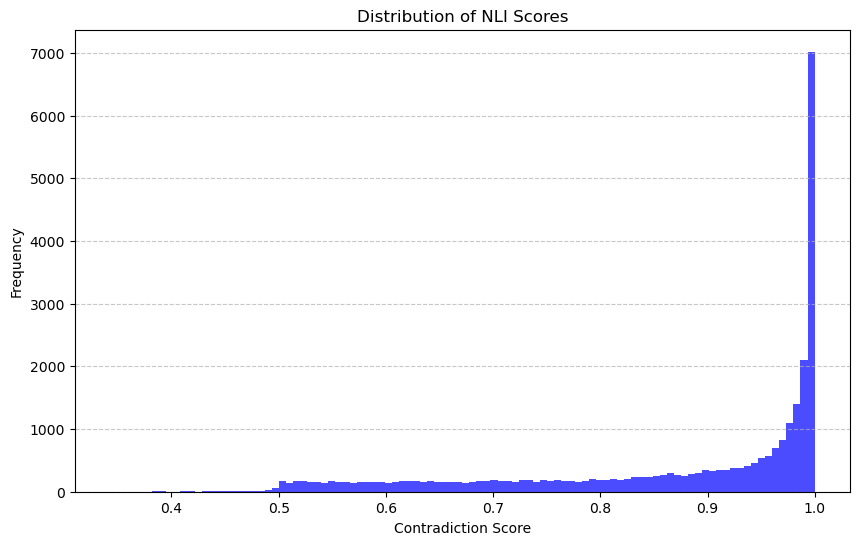

In [42]:
# Plot the distribution of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(contradictions_df['nli_score'], bins=100, color='blue', alpha=0.7)
plt.xlabel('Contradiction Score')
plt.ylabel('Frequency')
plt.title('Distribution of NLI Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot to a file if needed
# plt.savefig('../data/figures/all_approach/cross_encoder_score_distribution.png', dpi=300)

Sample the contradictions and see if they are. 

In [43]:
contradictions_sample_df = contradictions_df.sample(n=100, random_state=42)
contradictions_sample_df.to_csv("../data/similarity_scores/all_approach/sample")

## Looking at neutrals - Model 1 

In [44]:
neutrals_df = nli_scores_df[nli_scores_df["nli_label"] == "neutral"]
neutrals_df["nli_score"].describe()

count    4487.000000
mean        0.838199
std         0.166771
min         0.337484
25%         0.707649
50%         0.907646
75%         0.983341
max         0.999590
Name: nli_score, dtype: float64

## Looking at entailments - Model 1 

The articles that support the open problem

In [45]:
entailments_df = nli_scores_df[nli_scores_df["nli_label"] == "entailment"]
entailments_df.head()

,open_problem_title,article_title,article_abstract,article_text,score,probability,nli_label,nli_score
1,Which changes in model organisms associated with ageing also change in a similar way in humans?,The regulation of physiological changes during mammalian aging,"Much evidence suggests that intrinsic molecular or cellular aging mechanisms need not be invoked to explain most age-related cellular changes and pathologcical conditions. Analysis of a widely scattered literature indicates that hormones and neural factors regulate a great number of cellular aging phenomena of mammals. It is proposed that age-related changes after maturation result from an extension of the neural and endocrine mechanisms that control earlier development and that produce a regulatory cascade of changing neural, endocrine, and target-tissue interactions.\n","The regulation of physiological changes during mammalian aging. Much evidence suggests that intrinsic molecular or cellular aging mechanisms need not be invoked to explain most age-related cellular changes and pathologcical conditions. Analysis of a widely scattered literature indicates that hormones and neural factors regulate a great number of cellular aging phenomena of mammals. It is proposed that age-related changes after maturation result from an extension of the neural and endocrine mechanisms that control earlier development and that produce a regulatory cascade of changing neural, endocrine, and target-tissue interactions.\n",7.106737,0.999181,entailment,0.951988
13,Which changes in model organisms associated with ageing also change in a similar way in humans?,Model systems for studies on cellular basis of organ ageing,"The cellular basis of the age-related decline in the functional capacity of many mammalian organs is still poorly understood. In this paper, the rat liver is presented as a promising model for studying cellular phenomena underlying organ ageing. The recent development of methods for isolation and purification of parenchymal, Kupffer and endothelial cells from the rat liver makes possible the comparison of functional and metabolic changes in the intact liver with changes in distinct liver cell classes isolated from rats of various age groups. An attempt has been made to correlate age changes in some important liver-specific functions, such as bromsulophthalein uptake and albumin synthesis, at the organ and at the cellular level. To compare cellular ageing phenomena in long-lived cells (parenchymal cells) and short lived cells (Kupffer and endothelial cells) from the same organ, the role of lysosomes in cellular ageing processes was investigated, with secial reference to the functioning of the lysosomal enzyme cathepsin D. The specific cathepsin D activity in Kupffer cells was abour 3 times higher than in endothelial cells and about 20 times higher than in parenchymal cells. The enzyme activity in the latter cell type showed a significant increase with age.\n","Model systems for studies on cellular basis of organ ageing. The cellular basis of the age-related decline in the functional capacity of many mammalian organs is still poorly understood. In this paper, the rat liver is presented as a promising model for studying cellular phenomena underlying organ ageing. The recent development of methods for isolation and purification of parenchymal, Kupffer and endothelial cells from the rat liver makes possible the comparison of functional and metabolic changes in the intact liver with changes in distinct liver cell classes isolated from rats of various age groups. An attempt has been made to correlate age changes in some important liver-specific functions, such as bromsulophthalein uptake and albumin synthesis, at the organ and at the cellular level. To compare cellular ageing phenomena in long-lived cells (parenchymal cells) and short lived cells (Kupffer and endothelial cells) from the same organ, the role of lysosomes in cellular ageing processes was investigated, with secial ref

We should look at the entailment scores, and select for high entailment. 

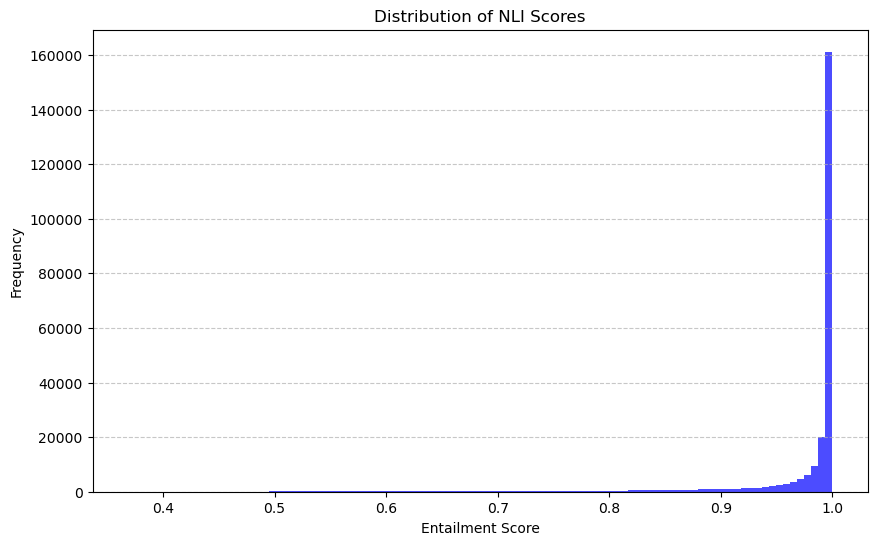

In [46]:
# Plot the distribution of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(entailments_df['nli_score'], bins=100, color='blue', alpha=0.7)
plt.xlabel('Entailment Score')
plt.ylabel('Frequency')
plt.title('Distribution of NLI Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot to a file if needed
plt.savefig('../data/figures/all_approach/entailment_score_distribution.png', dpi=300)

In [47]:
entailments_df["nli_score"].describe()

count    242207.000000
mean          0.969827
std           0.078219
min           0.368331
25%           0.987034
50%           0.997606
75%           0.999202
max           0.999853
Name: nli_score, dtype: float64

**Let's use 0.9 entailment score**

In [48]:
entailments_09_df = entailments_df[entailments_df["nli_score"] >= 0.9]

We should randomly sample and then decide whether 0.9 threshold is enough

In [49]:
entailment_sample_df = entailments_09_df.sample(n=200, random_state=42)
entailment_sample_df.to_csv("../data/similarity_scores/all_approach/entailment_09_threshold.csv")

### High similarity scoring and entailment 

In [50]:
cross_encoder_entailments_06_df = entailments_09_df[(entailments_09_df["probability"] >= 0.6) & (entailments_09_df["probability"] < 0.7)]
sample_06_df = cross_encoder_entailments_06_df.sample(100)

In [51]:
sample_06_df
sample_06_df.to_csv("../data/similarity_scores/all_approach/samples/06_similarity_entailment.csv")

In [52]:
sample_065_df = entailments_09_df[(entailments_09_df["probability"] >= 0.65) & (entailments_09_df["probability"] < 0.7)].sample(100, random_state=42)
sample_065_df.to_csv("../data/similarity_scores/all_approach/samples/065_similarity_entailment.csv")

In [53]:
sample_07_df = entailments_09_df[(entailments_09_df["probability"] >= 0.7) & (entailments_09_df["probability"] < 0.8)].sample(100, random_state=42)
sample_07_df.to_csv("../data/similarity_scores/all_approach/samples/07_similarity_entailment.csv")


In [54]:
sample_075_df = entailments_09_df[(entailments_09_df["probability"] >= 0.75) & (entailments_09_df["probability"] < 0.8)].sample(100, random_state=42)
sample_075_df.to_csv("../data/similarity_scores/all_approach/samples/075_similarity_entailment.csv")


In [55]:
sample_08_df = entailments_09_df[(entailments_09_df["probability"] >= 0.8) & (entailments_09_df["probability"] < 0.9)].sample(100, random_state=42)
sample_08_df.to_csv("../data/similarity_scores/all_approach/samples/08_similarity_entailment.csv")


### Comparing 0.75 and 0.8 thresholds

In [56]:
entailment_075_similarity_df = entailments_09_df[entailments_09_df["probability"] >= 0.75 ]
entailment_08_similarity_df = entailments_09_df[entailments_09_df["probability"] >= 0.8]

In [57]:
open_problems_grouped_08 = entailment_08_similarity_df.groupby('open_problem_title').size().reset_index(name='count').sort_values(by='count', ascending=False)
open_problems_grouped_075 = entailment_075_similarity_df.groupby('open_problem_title').size().reset_index(name='count').sort_values(by='count', ascending=False)


In [58]:
open_problems_grouped_08

,open_problem_title,count
193,Why do we age?,10808
30,Does mutation accumulation cause aging! or it is simply a adaptive response to aging-stress. Considering this can we utilize some of the age associated mutations against aging!,5977
181,Which cellular changes that contribute to ageing originate from within the cell?,4153
158,What determines species lifespans?,3921
175,What molecular and cellular processes modulate the pace of aging in mammals?,3885
...,...,...
50,How much do background electromagnetic waves and fields contribute to ageing?,7
117,How to break the glass ceiling of 120 years,4
130,Is the Hispanic paradox sufficiently substantiated within scientific discourse?,4
120,How to measure the extent of the homeodynmaic space,3


In [67]:
open_problems_grouped_075.to_csv("../data/open_problems_grouped_075.csv")
open_problems_grouped_08.to_csv("../data/open_problems_grouped_08.csv")

## Contradictions - Model 2 

In [9]:
nli_scores_2_df = pd.read_parquet("../data/similarity_scores/all_approach/nli_scores2.parquet")

In [10]:
contradictions_2_df = nli_scores_2_df[nli_scores_2_df["nli_label"] == "contradiction"]

In [18]:
def plot_histogram(column, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.hist(column, bins=100, color='blue', alpha=0.7)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('Distribution of NLI Scores')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    return plt 

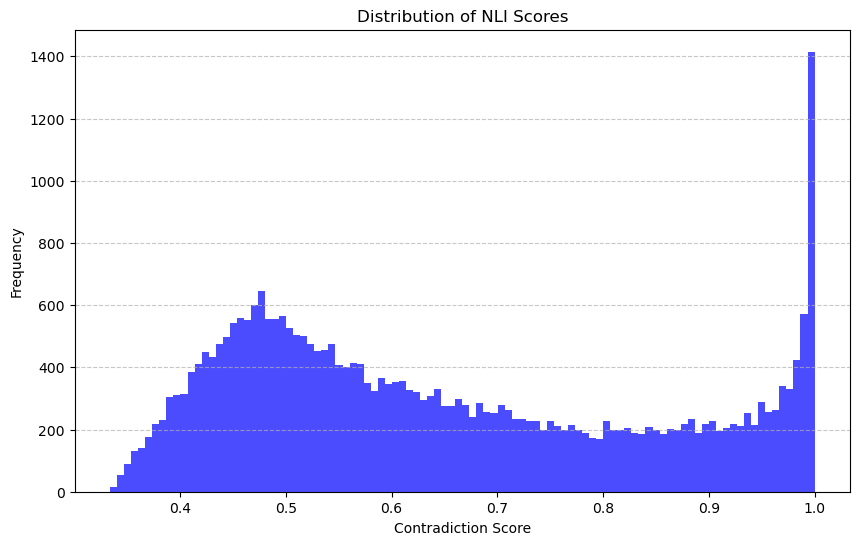

In [12]:
plot_contradictions = plot_histogram(contradictions_2_df["nli_score"], "Distribution of NLI Scores", "Contradiction Score", "Frequency")

## Entailments - Model 2 

In [13]:
entailments_2_df = nli_scores_2_df[nli_scores_2_df["nli_label"] == "entailment"]

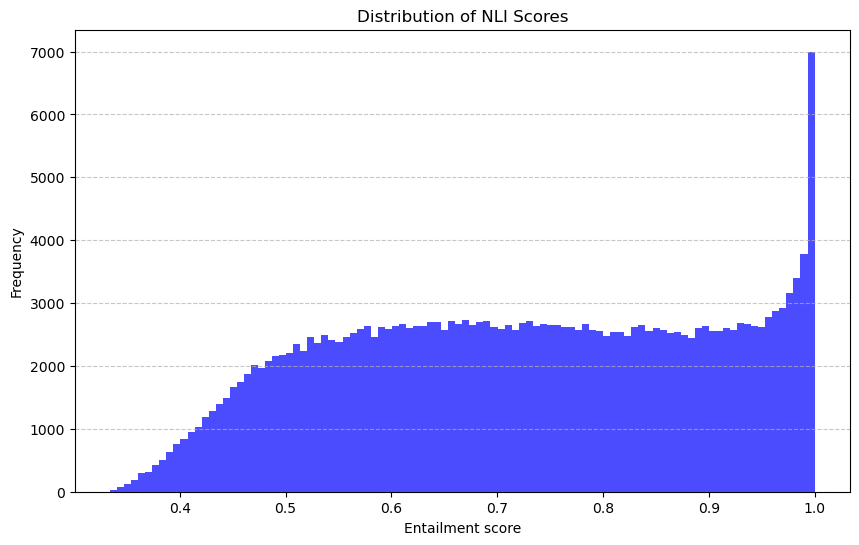

In [14]:
entailment_plot = plot_histogram(entailments_2_df["nli_score"], "Distribution of NLI Scores", "Entailment score", "Frequency")
entailment_plot.savefig("../data/figures/all_approach/entailment_dist_2.png", dpi=300)

In [15]:
entailments_2_df["nli_score"].describe()

count    228515.000000
mean          0.723948
std           0.171884
min           0.333962
25%           0.582474
50%           0.726357
75%           0.873185
max           1.000000
Name: nli_score, dtype: float64

In [16]:
pd.set_option('display.max_colwidth', None)

entailments_2_df.head()


,open_problem_title,article_title,article_abstract,article_text,score,probability,nli_label,nli_score
1,Which changes in model organisms associated with ageing also change in a similar way in humans?,The regulation of physiological changes during mammalian aging,"Much evidence suggests that intrinsic molecular or cellular aging mechanisms need not be invoked to explain most age-related cellular changes and pathologcical conditions. Analysis of a widely scattered literature indicates that hormones and neural factors regulate a great number of cellular aging phenomena of mammals. It is proposed that age-related changes after maturation result from an extension of the neural and endocrine mechanisms that control earlier development and that produce a regulatory cascade of changing neural, endocrine, and target-tissue interactions.\n","The regulation of physiological changes during mammalian aging. Much evidence suggests that intrinsic molecular or cellular aging mechanisms need not be invoked to explain most age-related cellular changes and pathologcical conditions. Analysis of a widely scattered literature indicates that hormones and neural factors regulate a great number of cellular aging phenomena of mammals. It is proposed that age-related changes after maturation result from an extension of the neural and endocrine mechanisms that control earlier development and that produce a regulatory cascade of changing neural, endocrine, and target-tissue interactions.\n",7.106737,0.999181,entailment,0.958182
13,Which changes in model organisms associated with ageing also change in a similar way in humans?,Model systems for studies on cellular basis of organ ageing,"The cellular basis of the age-related decline in the functional capacity of many mammalian organs is still poorly understood. In this paper, the rat liver is presented as a promising model for studying cellular phenomena underlying organ ageing. The recent development of methods for isolation and purification of parenchymal, Kupffer and endothelial cells from the rat liver makes possible the comparison of functional and metabolic changes in the intact liver with changes in distinct liver cell classes isolated from rats of various age groups. An attempt has been made to correlate age changes in some important liver-specific functions, such as bromsulophthalein uptake and albumin synthesis, at the organ and at the cellular level. To compare cellular ageing phenomena in long-lived cells (parenchymal cells) and short lived cells (Kupffer and endothelial cells) from the same organ, the role of lysosomes in cellular ageing processes was investigated, with secial reference to the functioning of the lysosomal enzyme cathepsin D. The specific cathepsin D activity in Kupffer cells was abour 3 times higher than in endothelial cells and about 20 times higher than in parenchymal cells. The enzyme activity in the latter cell type showed a significant increase with age.\n","Model systems for studies on cellular basis of organ ageing. The cellular basis of the age-related decline in the functional capacity of many mammalian organs is still poorly understood. In this paper, the rat liver is presented as a promising model for studying cellular phenomena underlying organ ageing. The recent development of methods for isolation and purification of parenchymal, Kupffer and endothelial cells from the rat liver makes possible the comparison of functional and metabolic changes in the intact liver with changes in distinct liver cell classes isolated from rats of various age groups. An attempt has been made to correlate age changes in some important liver-specific functions, such as bromsulophthalein uptake and albumin synthesis, at the organ and at the cellular level. To compare cellular ageing phenomena in long-lived cells (parenchymal cells) and short lived cells (Kupffer and endothelial cells) from the same organ, the role of lysosomes in cellular ageing processes was investigated, with secial ref

### Entailment score 0.5

In [17]:
entailment_2_05_df = entailments_2_df[(entailments_2_df["nli_score"] >= 0.5) & (entailments_2_df["nli_score"] < 0.6)]

In [18]:
random_sample_05 = entailment_2_05_df.sample(n=100, random_state=42)
random_sample_05.to_csv("../data/similarity_scores/all_approach/samples/05_similarity_entailment2.csv")

In [19]:
random_sample_05.head(5)

,open_problem_title,article_title,article_abstract,article_text,score,probability,nli_label,nli_score
17703,Which changes in model organisms associated with ageing also change in a similar way in humans?,Growth and aging: a common molecular mechanism,"It is commonly assumed that growth and aging are somehow linked, but the nature of this link has been elusive. Here we review the aging process as a continuation of TOR-driven growth. TOR is absolutely essential for developmental growth, but upon completion of development it causes aging and age-related diseases. Thus, the nutrient-sensing and growth-promoting TOR signaling pathway may provide a molecular link between growth and aging that is universal from yeast to human.\n","Growth and aging: a common molecular mechanism. It is commonly assumed that growth and aging are somehow linked, but the nature of this link has been elusive. Here we review the aging process as a continuation of TOR-driven growth. TOR is absolutely essential for developmental growth, but upon completion of development it causes aging and age-related diseases. Thus, the nutrient-sensing and growth-promoting TOR signaling pathway may provide a molecular link between growth and aging that is universal from yeast to human.\n",4.620731,0.990250,entailment,0.587051
1547832,What lifespan extension can we achieve if all hallmarks of aging are adressed at the same time?,Gut microbiota and aging-A focus on centenarians,"Gut microbiota (GM) is a dynamic organ throughout the lifespan. Aging is a complex process that comprises a plethora of mechanisms such as senescence, immunosenescence and inflammaging, representing important pathways of age-related diseases. GM structure could both influence and be influenced by aging occurring changes within the host. A unique category of long living individuals exists, namely centenarians that have the outstanding capacity to adapt to various challenges. Longevity seems to be associated with certain GM which, among other factors, might render individuals more resistant to age-related diseases and subsequently to long living. Diet, prebiotics, probiotics and synbiotics may contribute to longevity through GM modulating. Currently, the exact mechanisms of the association between GM and the host in relation with extended lifespan remain unknown and should be further investigated.\n","Gut microbiota and aging-A focus on centenarians. Gut microbiota (GM) is a dynamic organ throughout the lifespan. Aging is a complex process that comprises a plethora of mechanisms such as senescence, immunosenescence and inflammaging, representing important pathways of age-related diseases. GM structure could both influence and be influenced by aging occurring changes within the host. A unique category of long living individuals exists, namely centenarians that have the outstanding capacity to adapt to various challenges. Longevity seems to be associated with certain GM which, among other factors, might render individuals more resistant to age-related diseases and subsequently to long living. Diet, prebiotics, probiotics and synbiotics may contribute to longevity through GM modulating. Currently, the exact mechanisms of the association between GM and the host in relation with extended lifespan remain unknown and should be further investigated.\n",2.171633,0.897673,entailment,0.526717
531217,What mechanisms determine longevity of long-lived species?,Immunosenescence: emerging challenges for an ageing population,"It is now becoming apparent that the immune system undergoes age-associated alterations, which accumulate to produce a progressive deterioration in the ability to respond to infections and to develop immunity after vaccination, both of which are associated with a higher mortality rate in the elderly. Immunosenescence, defined as the changes in the immune system associated with age, has been gathering interest in the scientific and health-care sectors alike. The rise in its recognition is both pert

### Entailment score 0.6

In [20]:
entailment_2_06_df = entailments_2_df[(entailments_2_df["nli_score"] >= 0.6) & (entailments_2_df["nli_score"] < 0.7)]

In [21]:
random_sample_06 = entailment_2_06_df.sample(n=100, random_state=42)
random_sample_06.to_csv("../data/similarity_scores/all_approach/samples/06_similarity_entailment2.csv")

### Entailment score 0.7

In [22]:
entailment_2_07_df = entailments_2_df[(entailments_2_df["nli_score"] >= 0.7) & (entailments_2_df["nli_score"] < 0.8)]

In [23]:
random_sample_07 = entailment_2_07_df.sample(n=100, random_state=42)
random_sample_07.to_csv("../data/similarity_scores/all_approach/samples/07_similarity_entailment2.csv")

## Entailment score 1 

More specifically: 0.95 -> 1 

In [24]:
entailment_2_1_df = entailments_2_df[(entailments_2_df["nli_score"] >= 0.95) & (entailments_2_df["nli_score"] <= 1)]
entailment_2_1_df = entailment_2_1_df[entailment_2_1_df["probability"] >= 0.65]

In [25]:
random_sample_1 = entailment_2_1_df.sample(n=100, random_state=42)
random_sample_1.to_csv("../data/similarity_scores/all_approach/samples/1_similarity_entailment2.csv")

In [26]:
entailment_2_1_df["nli_score"].describe()

count    24402.000000
mean         0.979408
std          0.015269
min          0.950000
25%          0.966307
50%          0.981149
75%          0.993632
max          1.000000
Name: nli_score, dtype: float64

From inspection we should remove similarity scores that are below 0.65. 

In [27]:
open_problems2_grouped_1 = entailment_2_1_df.groupby('open_problem_title').size().reset_index(name='count').sort_values(by='count', ascending=False)
open_problems2_grouped_1.head(100)

,open_problem_title,count
189,Why do we age?,1130
178,Which cellular changes that contribute to ageing originate from within the cell?,626
172,What molecular and cellular processes modulate the pace of aging in mammals?,608
145,What are the causal hallmarks of aging?,554
30,Does mutation accumulation cause aging! or it is simply a adaptive response to aging-stress. Considering this can we utilize some of the age associated mutations against aging!,512
...,...,...
19,"Can we develop screens for anti-aging efficacy that will work in people (and mice), but whose effects do not require 5 - 40 years to measure in people?",78
108,How much does the immune response to mutated cells contribute to ageing?,78
61,How much does SASP contribute to ageing?,77
190,"Why does ageing manifests differently in humans, even close relatives?",77


We should also add the problems that are not included at the bottom. 

In [34]:
open_problems2_grouped_1.head()

,open_problem_title,count
189,Why do we age?,1130
178,Which cellular changes that contribute to ageing originate from within the cell?,626
172,What molecular and cellular processes modulate the pace of aging in mammals?,608
145,What are the causal hallmarks of aging?,554
30,Does mutation accumulation cause aging! or it is simply a adaptive response to aging-stress. Considering this can we utilize some of the age associated mutations against aging!,512


In [38]:
filtered_df = nli_scores_2_df[~nli_scores_2_df['open_problem_title'].isin(open_problems2_grouped_1['open_problem_title'])]

# Get unique values of the 'open_problem_title' column
unique_titles = filtered_df['open_problem_title'].unique()

missing_df = pd.DataFrame({
    "open_problem_title": unique_titles, 
    "count": 0
})

open_problems2_grouped_1 = pd.concat([open_problems2_grouped_1, missing_df], ignore_index=True)
open_problems2_grouped_1.tail()

,open_problem_title,count
195,"Which interventions should be prioritized? (How, when, what dose and route)",0
196,How to measure the pace of the shrinkage of the homeodynamic space.,0
197,Is the Hispanic paradox sufficiently substantiated within scientific discourse?,0
198,How much do background electromagnetic waves and fields contribute to ageing?,0
199,"Are there current or prospective synthetic methodologies that integrate additional diagnostic modalities, such as brain MRI scans, cardiac treadmill tests, etc?",0


In [39]:
open_problems2_grouped_1.to_csv("../data/open_problems2_grouped_1.csv")

# Refinements 

Open problems to remove from the grouped open problem titles. 

In [10]:
to_remove_df = pd.read_csv("../data/to_remove.csv")
to_remove_df

,open_problem_title
0,"Which tissues, organs or cell types contribute..."
1,Why do genetically identical organisms (e.g. C...
2,Why do genetically identical mice (lab strains...
3,How much does excessive cell death contribute ...
4,How much does suboptimal cell proliferation co...
5,What controls maximum species lifespan?
6,"We need to understand what we die of, what are..."
7,We need to have a systems biology model of agi...
8,Aging and the immune-neurohumoral homeostasis ...
9,How to measure intrinsic biological age in ind...


In [16]:
final_list_df = pd.read_csv("../data/open_problems_grouped_08.csv")
final_list_df = final_list_df[~final_list_df["open_problem_title"].isin(to_remove_df["open_problem_title"])]
final_list_df = final_list_df.loc[:,["open_problem_title", "count"]].reset_index(drop=True)

final_list_df

,open_problem_title,count
0,Why do we age?,10808
1,Does mutation accumulation cause aging! or it ...,5977
2,Which cellular changes that contribute to agei...,4153
3,What determines species lifespans?,3921
4,What molecular and cellular processes modulate...,3885
...,...,...
184,How much do background electromagnetic waves a...,7
185,How to break the glass ceiling of 120 years,4
186,Is the Hispanic paradox sufficiently substanti...,4
187,How to measure the extent of the homeodynmaic ...,3


## Add any merged open open problems.

Add the new open probems (these were made through merging two similart open problems together after inspection). Put them through the selected workflow and then add it to the open problems data, then save to file. 

- Cross encode every pairing of the open problems and articles
- Get the pairings that have at least 0.8 probability.
- Then run the nli inference model, select for 0.9 entailment.
- Add the results to the main dataframe. 

In [17]:
to_add_df = pd.read_csv("../data/to_add.csv")

In [18]:
all_articles_df = pd.read_parquet("../data/similarity_scores/article_embeddings.parquet")

In [19]:
all_open_problem_embeddings_df = pd.read_parquet("../data/similarity_scores/open_problem_embeddings.parquet")

In [20]:
all_open_problem_embeddings_df

,open_problem_title,embedding
0,Which changes in model organisms associated wi...,"[0.4431162476539612, 0.06975164264440536, 0.86..."
1,Can we come up with better markers that repres...,"[-0.005452389363199472, 0.4297190010547638, 0...."
2,Which cellular changes that contribute to agei...,"[-0.36370939016342163, 0.6428638696670532, 0.4..."
3,Are there are specific tissues or cell types t...,"[0.1256828010082245, 0.3153263330459595, 0.440..."
4,Can we apply stem cell therapy based on our ow...,"[-0.21353283524513245, -0.15867210924625397, -..."
...,...,...
196,Why do we age?,"[0.3394831120967865, 0.26872119307518005, 0.65..."
197,What is the biological basis of epigenetic clo...,"[0.3287297785282135, 0.7015529274940491, 0.301..."
198,What is the role of senescent cells in normal ...,"[-0.13240481913089752, -0.47163131833076477, -..."
199,What determines species lifespans?,"[0.22658495604991913, 0.47073668241500854, 0.7..."


### Cosine similarity 

In [21]:
model = SentenceTransformer("neuml/pubmedbert-base-embeddings")

/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to con

In [22]:
embeddings = model.encode(to_add_df["open_problem_title"].tolist(), 
                                            batch_size=64, show_progress_bar=True)

Batches: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


In [23]:
to_add_df["open_problem_embedding"] = embeddings.tolist()
to_add_df

,open_problem_title,submitted_by,open_problem_embedding
0,How do we measure intrinsic biological age in ...,conference,"[0.29737135767936707, 0.371876984834671, 0.157..."


In [24]:
# Add the new embeddings to all the open problem embeddings list. 
to_add_embeddings_df = to_add_df.rename(columns={"open_problem_embedding": "embedding"})
all_open_problem_embeddings_df = pd.concat([all_open_problem_embeddings_df, to_add_embeddings_df.loc[:,["open_problem_title", "embedding"]]], ignore_index=True)
all_open_problem_embeddings_df.to_parquet("../data/similarity_scores/all_approach/open_problem_embeddings.parquet")

In [25]:
# cross join 
problem_article_pairs_df = to_add_df.loc[:,["open_problem_title","open_problem_embedding"]].merge(all_articles_df, how="cross")
problem_article_pairs_df.head()

,open_problem_title,open_problem_embedding,article_title,article_abstract,article_text,embedding
0,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",Phospholipase A2 as a probe of phospholipid di...,The action of snake venom phospholipases A2 in...,Phospholipase A2 as a probe of phospholipid di...,"[0.03324238583445549, -0.10877010226249695, -0..."
1,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",Bile acids. XLVII. 12alpha-Hydroxylation of pr...,Rabbit liver microsomal preparations fortified...,Bile acids. XLVII. 12alpha-Hydroxylation of pr...,"[0.31813573837280273, 0.10684096068143845, -0...."
2,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",Spontaneous mortality and vascular lesions in ...,We have observed a high and significant mortal...,Spontaneous mortality and vascular lesions in ...,"[0.6937615871429443, -0.07225436717271805, 0.1..."
3,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",Peroxisome development in the metanephric kidn...,The relationship of enzymatic activity to orga...,Peroxisome development in the metanephric kidn...,"[0.103456512093544, 0.09430592507123947, 0.160..."
4,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",Effect on aging on plasma renin and aldosteron...,The influence of aging on the renin-angiotensi...,Effect on aging on plasma renin and aldosteron...,"[0.09751694649457932, -0.017173567786812782, -..."


In [26]:
# calculate cosine sim and remove scores below 0.2 
# Convert lists to numpy arrays
problem_article_pairs_df['open_problem_embedding'] = problem_article_pairs_df['open_problem_embedding'].apply(np.array)
problem_article_pairs_df['embedding'] = problem_article_pairs_df['embedding'].apply(np.array)

# Calculate cosine similarity using sentence_transformers util.cos_sim
problem_article_pairs_df['cosine_similarity'] = problem_article_pairs_df.apply(lambda row: util.cos_sim(row['open_problem_embedding'], 
                                                            row['embedding']).item(), axis=1)

In [27]:
filtered_cosines_df = problem_article_pairs_df[problem_article_pairs_df["cosine_similarity"] >= 0.2]
filtered_cosines_df.to_parquet("../data/similarity_scores/all_approach/additional_cosine_scores.parquet")

In [28]:
filtered_cosines_df

,open_problem_title,open_problem_embedding,article_title,article_abstract,article_text,embedding,cosine_similarity
5,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",The late effects of selected immunosuppressant...,The late effects of various immunosuppressive ...,The late effects of selected immunosuppressant...,"[0.2511870265007019, -0.24985745549201965, 0.1...",0.207868
30,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",The regulation of physiological changes during...,Much evidence suggests that intrinsic molecula...,The regulation of physiological changes during...,"[0.29266616702079773, -0.24228020012378693, 0....",0.358560
34,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",An exploratory investigation of the personalit...,The Hand Test was administered to 27 older adu...,An exploratory investigation of the personalit...,"[0.020309684798121452, -0.19087684154510498, -...",0.254897
50,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",Aging and extrapyramidal function,Measurements on human brain samples of some en...,Aging and extrapyramidal function. Measurement...,"[-0.15028704702854156, 0.05991416797041893, 0....",0.256111
54,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",A multiple-parameter comparison of immunocompe...,Several parameters of cell-mediated and humora...,A multiple-parameter comparison of immunocompe...,"[0.3121017515659332, -0.3266233503818512, 0.16...",0.241177
...,...,...,...,...,...,...,...
200201,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",Magnitude and kinetics of a set of neuroanatom...,Even among the subjects classified as cognitiv...,Magnitude and kinetics of a set of neuroanatom...,"[-0.10198265314102173, 0.5401151180267334, 0.4...",0.215126
200210,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",Exploring Multifunctional Markers of Biologica...,DNA methylation clocks provide information not...,Exploring Multifunctional Markers of Biologica...,"[0.213596910238266, 0.009477343410253525, 0.81...",0.249373
200218,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",A Structural Equation Model for Understanding ...,"In recent years, aging has become a focal poin...",A Structural Equation Model for Understanding ...,"[0.02692405693233013, -0.25933200120925903, 0....",0.216711
200219,How do we measure intrinsic biological age in ...,"[0.29737135767936707, 0.371876984834671, 0.157...",Interventions to Promote Physical Activity and...,The Healthy Ageing Challenge aims for people t...,Interventions to Promote Physical Activity and...,"[-0.07299122214317322, 0.3098424971103668, -0....",0.278790


### Cross-encoder 

In [29]:
problem_article_pairs_df = pd.read_parquet("../data/similarity_scores/all_approach/additional_cosine_scores.parquet")
problem_article_pairs_df = problem_article_pairs_df.loc[:, ["open_problem_title", "article_title", "article_abstract","article_text", "cosine_similarity"]]

In [30]:
tokenizer = AutoTokenizer.from_pretrained("ncbi/MedCPT-Cross-Encoder")
model = AutoModelForSequenceClassification.from_pretrained("ncbi/MedCPT-Cross-Encoder")
model.to("cuda")

/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [31]:
class ProblemArticleDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return row["open_problem_title"], row["article_text"]

# Instantiate the dataset and dataloader with a reduced batch size
dataset = ProblemArticleDataset(problem_article_pairs_df)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

# Function to compute scores in batches
def compute_scores_in_batch(batch):
    titles, article_texts = batch
    pairs = list(zip(titles, article_texts))

    with torch.no_grad():
        encoded = tokenizer(
            pairs,
            truncation=True,
            padding=True,
            return_tensors='pt',
            max_length=512
        )

        # Move tensors to CUDA
        encoded = {key: value.to('cuda') for key, value in encoded.items()}
        logits = model(**encoded).logits
        scores = logits[:, 0].cpu().tolist()  # Get the scores for each pair
    
    return scores

# Compute scores for all batches
all_scores = []
for batch in tqdm(dataloader, desc="Computing scores"):
    batch_scores = compute_scores_in_batch(batch)
    all_scores.extend(batch_scores)

# Add scores to the dataframe
problem_article_pairs_df["score"] = all_scores

Computing scores: 100%|██████████| 3983/3983 [03:05<00:00, 21.50it/s]


In [32]:
# convert to probability - sigmoid function 
# Function to convert logits to probabilities using sigmoid
def logit_to_probability(logit):
    return torch.sigmoid(torch.tensor(logit)).item()

sigmoid_probabilities = problem_article_pairs_df["score"].apply(logit_to_probability)
problem_article_pairs_df["probability"] = sigmoid_probabilities

In [33]:
problem_article_pairs_df.head()

,open_problem_title,article_title,article_abstract,article_text,cosine_similarity,score,probability
5,How do we measure intrinsic biological age in ...,The late effects of selected immunosuppressant...,The late effects of various immunosuppressive ...,The late effects of selected immunosuppressant...,0.207868,-10.874758,0.000019
30,How do we measure intrinsic biological age in ...,The regulation of physiological changes during...,Much evidence suggests that intrinsic molecula...,The regulation of physiological changes during...,0.358560,8.496628,0.999796
34,How do we measure intrinsic biological age in ...,An exploratory investigation of the personalit...,The Hand Test was administered to 27 older adu...,An exploratory investigation of the personalit...,0.254897,-12.677842,0.000003
50,How do we measure intrinsic biological age in ...,Aging and extrapyramidal function,Measurements on human brain samples of some en...,Aging and extrapyramidal function. Measurement...,0.256111,-7.637717,0.000482
54,How do we measure intrinsic biological age in ...,A multiple-parameter comparison of immunocompe...,Several parameters of cell-mediated and humora...,A multiple-parameter comparison of immunocompe...,0.241177,-11.942312,0.000007


In [34]:
problem_article_pairs_df["probability"].describe()

count    3.186400e+04
mean     1.376541e-01
std      3.077463e-01
min      1.290203e-07
25%      7.311542e-06
50%      1.502714e-04
75%      1.974096e-02
max      9.999999e-01
Name: probability, dtype: float64

<module 'matplotlib.pyplot' from '/rds/bear-apps/2022b/EL8-ice/software/matplotlib/3.7.0-gfbf-2022b/lib/python3.10/site-packages/matplotlib/pyplot.py'>

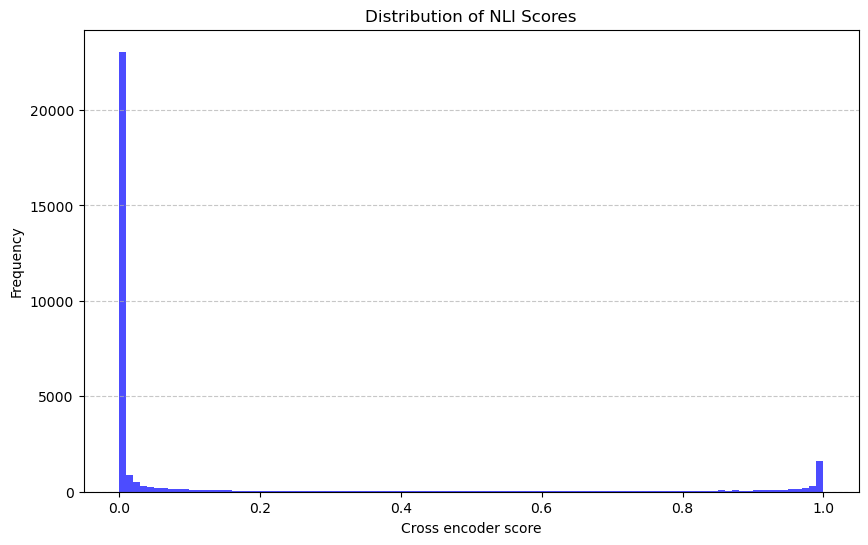

In [37]:
plot_histogram(problem_article_pairs_df["probability"],"Cross Encoder Score Distrubution", "Cross encoder score", "Frequency")

In [ ]:
new_threshold_08 = problem_article_pairs_df[problem_article_pairs_df["probability"] >= 0.8]
new_threshold_08.to_csv("../data/similarity_scores/all_approach/additional_cross_scores.csv")

Now let's run the NLI model. Remember that the cross encoder threshold is 0.5 for now.  

In [ ]:
model_name = "pritamdeka/PubMedBERT-MNLI-MedNLI"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, id2label={1: 'entailment', 0: 'contradiction', 2: 'neutral'})
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0,
    batch_size=128,
    # Setting the truncation and max_length when using the pipeline
    max_length=512,
    truncation=True
)

In [ ]:
def apply_nli(row):
    try:
        premise = row['article_text']
        hypothesis = row["open_problem_title"]
        
        # Use pipe for prediction; this will return a list of results, each result itself being a list of label/score pairs
        result = pipe([f"{hypothesis} [SEP] {premise}"], truncation=True, max_length=512)[0]

        # Extract scores
        label_scores = {item['label']: item['score'] for item in result}
        label = max(label_scores, key=label_scores.get)
        score = label_scores[label]

        return label, score
    except Exception as e:
        print(f"Error processing row: {e}")
        return None, None


In [ ]:
additional_nli_scores_df = pd.read_csv("../data/similarity_scores/all_approach/additional_cross_scores.csv")

In [ ]:
tqdm.pandas()
additional_nli_scores_df[['nli_label', 'nli_score']] = additional_nli_scores_df.progress_apply(lambda row: pd.Series(apply_nli(row)), axis=1)


In [ ]:
pd.set_option('display.max_colwidth', None)

filtered_scores_df = additional_nli_scores_df[additional_nli_scores_df["nli_label"] == "entailment"]
filtered_scores_df = filtered_scores_df[filtered_scores_df["nli_score"] >= 0.9]
filtered_scores_df

In [ ]:
random_sample = filtered_scores_df.sample(n=100, random_state=42)

In [ ]:
random_sample.to_csv("../data/similarity_scores/all_approach/samples/additional_sample.csv")

In [ ]:
pd.reset_option("display.max_colwidth")

### Get the counts and add them to the grouped_list 

In [ ]:
final_list_df

In [ ]:
additional_grouped_df = filtered_scores_df.groupby('open_problem_title').size().reset_index(name='count')
additional_grouped_df

In [27]:
# concatenate together
final_combined_open_problems = pd.concat([final_list_df, additional_grouped_df], ignore_index=True)
final_combined_open_problems = final_combined_open_problems.sort_values("count", ascending=False)

In [28]:
final_combined_open_problems.to_csv("../data/similarity_scores/final_revisions/final_grouped_open_problems1.csv")

## Get counts for new open problems. 

In [34]:
all_open_problems_df = pd.read_csv("../data/groupings/custom_grouped_open_problems2.csv")

In [29]:
previous_open_problems = pd.read_csv("../data/similarity_scores/final_revisions/final_grouped_open_problems1.csv", index_col=0)

In [76]:
article_embeddings_df = pd.read_parquet("../data/similarity_scores/article_embeddings.parquet")

In [78]:
# Ensure 'open_problem_title' is stripped of whitespaces in both DataFrames
all_open_problems['open_problem_title'] = all_open_problems['open_problem_title'].str.strip()
previous_open_problems['open_problem_title'] = previous_open_problems['open_problem_title'].str.strip()

# Find titles in 'all_open_problems' that are not in 'previous_open_problems'
new_open_problems = all_open_problems[
    ~all_open_problems['open_problem_title'].isin(previous_open_problems['open_problem_title'])
]

# Display or save the result
new_open_problems

,Unnamed: 0,open_problem_title,updated_final_label
4,4,How much of ageing is protective (e.g. from ca...,Ageing and Disease
13,13,How do we validate biomarkers of health and va...,Biomarkers and Measurement
16,16,How to measure intrinsic biological age in ind...,Biomarkers and Measurement
24,24,How are cellular changes connected to patholog...,Cellular Processes
34,34,How much does excessive cell death contribute ...,Cellular Processes
37,37,How much does suboptimal cell proliferation co...,Cellular Processes
44,44,How do we find the major common denominators o...,Comparative Ageing and Evolution
99,99,"We need to understand what we die of, what are...",Health and Lifestyle Factors
109,109,Aging and the immune-neurohumoral homeostasis ...,Immune System and Inflammation
121,121,Are there current or prospective synthetic met...,Interventions (Pharmacological and Non-Pharmac...


In [79]:
model = SentenceTransformer("neuml/pubmedbert-base-embeddings")
title_embeddings = model.encode(new_open_problems["open_problem_title"].tolist())
new_open_problems['embedding'] = list(title_embeddings)  # Convert NumPy array to list of arrays for DataFrame


/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

In [81]:
open_problem_embeddings = np.vstack(new_open_problems['embedding'].values)
article_embeddings = np.vstack(article_embeddings_df['embedding'].values)

In [84]:
# Convert both embeddings to float32
open_problem_embeddings = torch.tensor(open_problem_embeddings, dtype=torch.float32)
article_embeddings = torch.tensor(article_embeddings, dtype=torch.float32)

In [85]:
# Ensure titles come from the correct DataFrames
open_problem_titles = np.repeat(new_open_problems['open_problem_title'].values, len(article_embeddings))
article_titles = np.tile(article_embeddings_df['article_title'].values, len(open_problem_embeddings))
article_abstracts = np.tile(article_embeddings_df['article_abstract'].values, len(open_problem_embeddings))

# Compute similarity scores
similarity_scores = util.cos_sim(open_problem_embeddings, article_embeddings)

# Flatten similarity scores
similarity_scores_flat = similarity_scores.numpy().flatten()

In [89]:
# Create a DataFrame in long format
long_similarity_df = pd.DataFrame({
    'open_problem_title': open_problem_titles,
    'article_title': article_titles,
    'article_abstract': article_abstracts,
    'similarity_score': similarity_scores_flat
})

long_similarity_df.to_parquet("../data/similarity_scores/all_approach/new_similarity_scores.parquet")

In [90]:
long_similarity_df

,open_problem_title,article_title,article_abstract,similarity_score
0,How much of ageing is protective (e.g. from ca...,Phospholipase A2 as a probe of phospholipid di...,The action of snake venom phospholipases A2 in...,0.003781
1,How much of ageing is protective (e.g. from ca...,Bile acids. XLVII. 12alpha-Hydroxylation of pr...,Rabbit liver microsomal preparations fortified...,-0.097618
2,How much of ageing is protective (e.g. from ca...,Spontaneous mortality and vascular lesions in ...,We have observed a high and significant mortal...,-0.018753
3,How much of ageing is protective (e.g. from ca...,Peroxisome development in the metanephric kidn...,The relationship of enzymatic activity to orga...,-0.066527
4,How much of ageing is protective (e.g. from ca...,Effect on aging on plasma renin and aldosteron...,The influence of aging on the renin-angiotensi...,0.096886
...,...,...,...,...
3003415,Why do genetically identical organisms (e.g. C...,Filbertone Reduces Senescence in C2C12 Myotube...,"It has been demonstrated that filbertone, the ...",-0.053137
3003416,Why do genetically identical organisms (e.g. C...,Balancing the Oral-Gut-Brain Axis with Diet,Background: The oral microbiota is the second ...,0.128264
3003417,Why do genetically identical organisms (e.g. C...,"Piperine, a black pepper compound, induces aut...",Acute leukemia is characterized by abnormal wh...,-0.159977
3003418,Why do genetically identical organisms (e.g. C...,Alterations of senescence-associated markers i...,Non-syndromic cleft lip with or without cleft ...,-0.016658


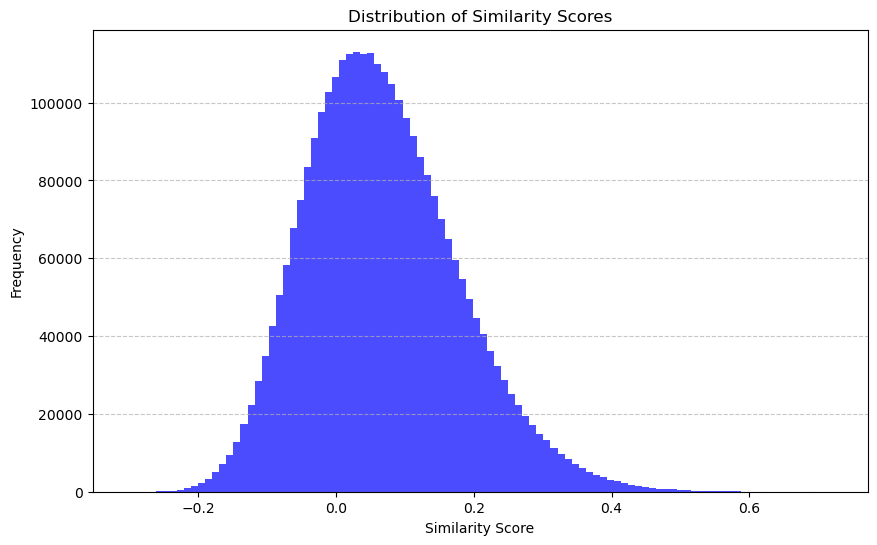

In [94]:
# Plot the distribution of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(long_similarity_df['similarity_score'], bins=100, color='blue', alpha=0.7)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot to a file if needed


In [95]:
above_02_score_df = long_similarity_df[long_similarity_df["similarity_score"] >= 0.2]
above_02_score_df.to_parquet("../data/similarity_scores/all_approach/additional_upper_quartile_scores.parquet")

### Cross-encoder

In [27]:
cross_encoder_scores_df = pd.read_parquet("../data/similarity_scores/all_approach/additional_cross_encoder_scores.parquet")

In [28]:
# Convert to probability 
# Function to convert logits to probabilities using sigmoid
def logit_to_probability(logit):
    return torch.sigmoid(torch.tensor(logit)).item()

# Apply the sigmoid function to the 'score' column to get probabilities
cross_encoder_scores_df['probability'] = cross_encoder_scores_df['score'].apply(logit_to_probability)

In [29]:
cross_encoder_scores_df.head()

,open_problem_title,article_title,article_abstract,article_text,score,probability
5,How much of ageing is protective (e.g. from ca...,The late effects of selected immunosuppressant...,The late effects of various immunosuppressive ...,The late effects of selected immunosuppressant...,-12.172398,5.171216e-06
20,How much of ageing is protective (e.g. from ca...,Age dependence of the number of the stem cells...,The number and concentration of haemopoietic s...,Age dependence of the number of the stem cells...,-15.715414,1.495830e-07
30,How much of ageing is protective (e.g. from ca...,The regulation of physiological changes during...,Much evidence suggests that intrinsic molecula...,The regulation of physiological changes during...,-10.167465,3.839806e-05
35,How much of ageing is protective (e.g. from ca...,Cellular immunity against bacteria (intracellu...,The authors study the activity of RES in rats ...,Cellular immunity against bacteria (intracellu...,-15.322339,2.216117e-07
50,How much of ageing is protective (e.g. from ca...,Aging and extrapyramidal function,Measurements on human brain samples of some en...,Aging and extrapyramidal function. Measurement...,-15.629990,1.629227e-07


In [30]:
# 0.5 threshold 
threshold_05_df = cross_encoder_scores_df[cross_encoder_scores_df["probability"] >= 0.5]
threshold_05_df

,open_problem_title,article_title,article_abstract,article_text,score,probability
1814,How much of ageing is protective (e.g. from ca...,"Aging, environmental influences, and photocarc...",Repeated exposure of human skin to solar ultra...,"Aging, environmental influences, and photocarc...",1.499340,0.817476
1935,How much of ageing is protective (e.g. from ca...,Preventive medicine in adults. Fundamentals an...,The Author puts in evidence the need of a real...,Preventive medicine in adults. Fundamentals an...,0.242316,0.560284
2844,How much of ageing is protective (e.g. from ca...,Aging: biologic or pathologic?,If disease is only case casually related to ag...,Aging: biologic or pathologic?. If disease is ...,5.423754,0.995609
3599,How much of ageing is protective (e.g. from ca...,Why do human cancer death rates increase with ...,"1. Cancers, viewed as escape from the normal ""...",Why do human cancer death rates increase with ...,0.844187,0.699346
3649,How much of ageing is protective (e.g. from ca...,The effect of nutrition on aging,It is possible to prevent some degenerative pr...,The effect of nutrition on aging. It is possib...,1.295769,0.785122
...,...,...,...,...,...,...
3003033,Why do genetically identical organisms (e.g. C...,Targeting multiple hallmarks of mammalian agin...,Aging is currently viewed as a result of multi...,Targeting multiple hallmarks of mammalian agin...,2.487408,0.923254
3003084,Why do genetically identical organisms (e.g. C...,Dissecting the impact of differentiation stage...,"Epigenetic clocks, built on DNA methylation pa...",Dissecting the impact of differentiation stage...,0.302272,0.574998
3003191,Why do genetically identical organisms (e.g. C...,ImAge quantitates aging and rejuvenation,"For efficient, cost-effective and personalized...",ImAge quantitates aging and rejuvenation. For ...,3.815828,0.978455
3003286,Why do genetically identical organisms (e.g. C...,The inflammaging clock strikes IL-11!,Chronic inflammation is considered a hallmark ...,The inflammaging clock strikes IL-11!. Chronic...,0.286394,0.571113


### NLI Analysis 

In [31]:
model_name = "pritamdeka/PubMedBERT-MNLI-MedNLI"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, id2label={1: 'entailment', 0: 'contradiction', 2: 'neutral'})
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0,
    batch_size=128,
    # Setting the truncation and max_length when using the pipeline
    max_length=512,
    truncation=True
)

/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` i

In [32]:
def apply_nli(row):
    try:
        premise = row['article_text']
        hypothesis = row["open_problem_title"]
        
        # Use pipe for prediction; this will return a list of results, each result itself being a list of label/score pairs
        result = pipe([f"{hypothesis} [SEP] {premise}"], truncation=True, max_length=512)[0]

        # Extract scores
        label_scores = {item['label']: item['score'] for item in result}
        label = max(label_scores, key=label_scores.get)
        score = label_scores[label]

        return label, score
    except Exception as e:
        print(f"Error processing row: {e}")
        return None, None

In [33]:
nli_scores_df = threshold_05_df.copy()

In [34]:
tqdm.pandas()
nli_scores_df[['nli_label', 'nli_score']] = nli_scores_df.progress_apply(lambda row: pd.Series(apply_nli(row)), axis=1)


  0%|          | 2/18131 [00:04<12:11:12,  2.42s/it]/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-analysis-venv-icelake/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 18131/18131 [02:26<00:00, 123.35it/s]


In [35]:
nli_scores_df

,open_problem_title,article_title,article_abstract,article_text,score,probability,nli_label,nli_score
1814,How much of ageing is protective (e.g. from ca...,"Aging, environmental influences, and photocarc...",Repeated exposure of human skin to solar ultra...,"Aging, environmental influences, and photocarc...",1.499340,0.817476,entailment,0.989824
1935,How much of ageing is protective (e.g. from ca...,Preventive medicine in adults. Fundamentals an...,The Author puts in evidence the need of a real...,Preventive medicine in adults. Fundamentals an...,0.242316,0.560284,entailment,0.791052
2844,How much of ageing is protective (e.g. from ca...,Aging: biologic or pathologic?,If disease is only case casually related to ag...,Aging: biologic or pathologic?. If disease is ...,5.423754,0.995609,entailment,0.984780
3599,How much of ageing is protective (e.g. from ca...,Why do human cancer death rates increase with ...,"1. Cancers, viewed as escape from the normal ""...",Why do human cancer death rates increase with ...,0.844187,0.699346,contradiction,0.970502
3649,How much of ageing is protective (e.g. from ca...,The effect of nutrition on aging,It is possible to prevent some degenerative pr...,The effect of nutrition on aging. It is possib...,1.295769,0.785122,entailment,0.926025
...,...,...,...,...,...,...,...,...
3003033,Why do genetically identical organisms (e.g. C...,Targeting multiple hallmarks of mammalian agin...,Aging is currently viewed as a result of multi...,Targeting multiple hallmarks of mammalian agin...,2.487408,0.923254,entailment,0.984182
3003084,Why do genetically identical organisms (e.g. C...,Dissecting the impact of differentiation stage...,"Epigenetic clocks, built on DNA methylation pa...",Dissecting the impact of differentiation stage...,0.302272,0.574998,entailment,0.969878
3003191,Why do genetically identical organisms (e.g. C...,ImAge quantitates aging and rejuvenation,"For efficient, cost-effective and personalized...",ImAge quantitates aging and rejuvenation. For ...,3.815828,0.978455,entailment,0.999764
3003286,Why do genetically identical organisms (e.g. C...,The inflammaging clock strikes IL-11!,Chronic inflammation is considered a hallmark ...,The inflammaging clock strikes IL-11!. Chronic...,0.286394,0.571113,entailment,0.618211


In [36]:
filtered_nli_scores = nli_scores_df[
    (nli_scores_df['probability'] >= 0.8) &
    (nli_scores_df['nli_score'] >= 0.9) &
    (nli_scores_df['nli_label'] == 'entailment')
]

In [37]:
filtered_nli_scores

,open_problem_title,article_title,article_abstract,article_text,score,probability,nli_label,nli_score
1814,How much of ageing is protective (e.g. from ca...,"Aging, environmental influences, and photocarc...",Repeated exposure of human skin to solar ultra...,"Aging, environmental influences, and photocarc...",1.499340,0.817476,entailment,0.989824
2844,How much of ageing is protective (e.g. from ca...,Aging: biologic or pathologic?,If disease is only case casually related to ag...,Aging: biologic or pathologic?. If disease is ...,5.423754,0.995609,entailment,0.984780
5573,How much of ageing is protective (e.g. from ca...,Senescence and pathology in ageing,The life expectancy of people living in the UK...,Senescence and pathology in ageing. The life e...,5.395390,0.995483,entailment,0.999567
5577,How much of ageing is protective (e.g. from ca...,Ageing and free radicals,Mammalian ageing is a universal phenomenon tha...,Ageing and free radicals. Mammalian ageing is ...,1.786439,0.856490,entailment,0.999323
6379,How much of ageing is protective (e.g. from ca...,Old age--a disease?,The process of aging is discussed in relation ...,Old age--a disease?. The process of aging is d...,5.966498,0.997443,entailment,0.988252
...,...,...,...,...,...,...,...,...
3002160,Why do genetically identical organisms (e.g. C...,Characterizing phenotypic data of Peromyscus l...,Translational research is commonly performed i...,Characterizing phenotypic data of Peromyscus l...,2.094723,0.890389,entailment,0.997975
3002397,Why do genetically identical organisms (e.g. C...,Longitudinal fragility phenotyping contributes...,Aging studies in mammalian models often depend...,Longitudinal fragility phenotyping contributes...,9.074374,0.999885,entailment,0.969842
3002955,Why do genetically identical organisms (e.g. C...,Animal Models Relevant for Geroscience: Curren...,"For centuries, aging was considered inevitable...",Animal Models Relevant for Geroscience: Curren...,1.941676,0.874536,entailment,0.998941
3003033,Why do genetically identical organisms (e.g. C...,Targeting multiple hallmarks of mammalian agin...,Aging is currently viewed as a result of multi...,Targeting multiple hallmarks of mammalian agin...,2.487408,0.923254,entailment,0.984182


In [38]:
# Count occurrences of each open problem in the filtered DataFrame
open_problem_counts = filtered_nli_scores['open_problem_title'].value_counts()

# Convert the counts to a DataFrame for better presentation
open_problem_counts_df = open_problem_counts.reset_index()
open_problem_counts_df.columns = ['open_problem_title', 'count']



In [39]:
# Combine the two DataFrames
final_list_df = pd.concat([open_problem_counts_df, previous_open_problems])

# Group by open_problem_title and sum the counts
final_list_df = final_list_df.groupby('open_problem_title', as_index=False)['count'].sum()

# Sort by the count column in descending order
final_list_df = final_list_df.sort_values(by='count', ascending=False)

# Display the combined and sorted DataFrame
final_list_df

NameError: name 'previous_open_problems' is not defined

In [ ]:
all_open_problems_df

**Merge the labels**

In [ ]:
# Merge the two DataFrames on the 'open_problem_title' column
merged_df = pd.merge(
    final_list_df,  # Replace with your counts DataFrame
    all_open_problems_df[['open_problem_title', 'updated_final_label']],  # Replace with your labels DataFrame
    on='open_problem_title',
    how='left'
)

# Display the merged DataFrame
merged_df

In [75]:
merged_df = merged_df.sort_values(by=["updated_final_label", "count"], ascending=[True,False])

In [76]:
merged_df

,open_problem_title,count,updated_final_label
10,What are the causal hallmarks of aging?,2801,Ageing Mechanisms
113,What is the epistatic contribution of differen...,375,Ageing Mechanisms
11,How much does ageing increase susceptibility t...,2678,Ageing and Disease
15,Does fundamental molecular ageing (damage/prog...,2366,Ageing and Disease
64,How much of ageing is protective (e.g. from ca...,793,Ageing and Disease
...,...,...,...
73,What determines heterogeneity in the rate and ...,669,Tissue-Specific Mechanisms
81,Why do genetically identical organisms (e.g. C...,628,Tissue-Specific Mechanisms
121,To what extent does the transformation of the ...,334,Tissue-Specific Mechanisms
13,How do we measure intrinsic biological age in ...,2545,NaN


In [78]:
merged_df.to_csv("../data/similarity_scores/final_revisions/final_grouped_open_problems2.csv")

**Here I manually inspect each row and may assign labels**

In [14]:
final_open_problems_df = pd.read_csv("../data/similarity_scores/final_revisions/final_grouped_open_problems2.csv", index_col=0)
counts = final_open_problems_df["count"].apply(lambda x: int(x))
final_open_problems_df["count"] = counts
final_open_problems_df = final_open_problems_df.sort_values(by=["final_group_label", "count"], ascending=[True,False])

In [16]:
final_open_problems_df

,Unnamed: 0,open_problem_title,count,final_group_label
0,94,Which mechanisms are essential for ageing acro...,1680,Ageing Mechanisms
1,1,What is the epistatic contribution of differen...,375,Ageing Mechanisms
2,0,What are the causal hallmarks of aging?,2801,Ageing Mechanisms
3,2,How much does ageing increase susceptibility t...,2678,Ageing and Disease
4,3,Does fundamental molecular ageing (damage/prog...,2366,Ageing and Disease
...,...,...,...,...
198,198,Will the use of AI speed up age reversal disco...,39,Technological Advances in Ageing Research
199,199,"Which tissues, organs or cell types contribute...",2016,Tissue-Specific Mechanisms
200,200,What are common tissue independent aging signa...,775,Tissue-Specific Mechanisms
201,201,What determines heterogeneity in the rate and ...,669,Tissue-Specific Mechanisms


In [9]:
final_open_problems_df.to_csv("../data/similarity_scores/final_revisions/final_grouped_open_problems2.csv")

### Combine dataset

Get the cosine similarity data after filtering for 0.2 

In [25]:
additional_upper_quartile_scores = pd.read_parquet("../data/similarity_scores/all_approach/additional_upper_quartile_scores.parquet")
additional_upper_quartile_scores

,open_problem_title,article_title,article_abstract,similarity_score
5,How much of ageing is protective (e.g. from ca...,The late effects of selected immunosuppressant...,The late effects of various immunosuppressive ...,0.291450
20,How much of ageing is protective (e.g. from ca...,Age dependence of the number of the stem cells...,The number and concentration of haemopoietic s...,0.218585
30,How much of ageing is protective (e.g. from ca...,The regulation of physiological changes during...,Much evidence suggests that intrinsic molecula...,0.365422
35,How much of ageing is protective (e.g. from ca...,Cellular immunity against bacteria (intracellu...,The authors study the activity of RES in rats ...,0.212301
50,How much of ageing is protective (e.g. from ca...,Aging and extrapyramidal function,Measurements on human brain samples of some en...,0.236922
...,...,...,...,...
3003347,Why do genetically identical organisms (e.g. C...,Quantifiable blood TCR repertoire components a...,T cell senescence alters the homeostasis of di...,0.262218
3003358,Why do genetically identical organisms (e.g. C...,Reducing the excessive inflammation after burn...,One in six people are projected to be 65 years...,0.303762
3003363,Why do genetically identical organisms (e.g. C...,Age-Disturbed Vascular Extracellular Matrix Li...,Abdominal aortic aneurysm (AAA) is a common bu...,0.207313
3003371,Why do genetically identical organisms (e.g. C...,Technology as a Fix for the Age-Old Challenge ...,"Health system leaders, researchers and the pub...",0.203218


In [24]:
initial_upper_quartile_scores = pd.read_parquet("../data/similarity_scores/all_approach/upper_quartile_scores.parquet")
initial_upper_quartile_scores

,open_problem_title,article_title,article_abstract,similarity_score
0,Which changes in model organisms associated wi...,The late effects of selected immunosuppressant...,The late effects of various immunosuppressive ...,0.208080
1,Which changes in model organisms associated wi...,The regulation of physiological changes during...,Much evidence suggests that intrinsic molecula...,0.518936
2,Which changes in model organisms associated wi...,An exploratory investigation of the personalit...,The Hand Test was administered to 27 older adu...,0.227924
3,Which changes in model organisms associated wi...,Cellular immunity against bacteria (intracellu...,The authors study the activity of RES in rats ...,0.203696
4,Which changes in model organisms associated wi...,Aging and extrapyramidal function,Measurements on human brain samples of some en...,0.223208
...,...,...,...,...
4544250,Can a drug slow human aging?,Involvement of Aryl Hydrocarbon Receptor in Lo...,"In previous studies, using transcriptomic anal...",0.216185
4544251,Can a drug slow human aging?,Interventions to Promote Physical Activity and...,The Healthy Ageing Challenge aims for people t...,0.418675
4544252,Can a drug slow human aging?,Searching for Beauty and Health: Aging in Wome...,"Women typically outlive men, yet they often ex...",0.306629
4544253,Can a drug slow human aging?,Botanical Bioflavonoid Composition from Scutel...,Oxidative stress and chronic inflammation crea...,0.220758


In [26]:
combined_upperquartile = pd.concat([additional_upper_quartile_scores, initial_upper_quartile_scores], ignore_index=True)
combined_upperquartile.to_parquet("../data/similarity_scores/")


,open_problem_title,article_title,article_abstract,similarity_score
0,How much of ageing is protective (e.g. from ca...,The late effects of selected immunosuppressant...,The late effects of various immunosuppressive ...,0.291450
1,How much of ageing is protective (e.g. from ca...,Age dependence of the number of the stem cells...,The number and concentration of haemopoietic s...,0.218585
2,How much of ageing is protective (e.g. from ca...,The regulation of physiological changes during...,Much evidence suggests that intrinsic molecula...,0.365422
3,How much of ageing is protective (e.g. from ca...,Cellular immunity against bacteria (intracellu...,The authors study the activity of RES in rats ...,0.212301
4,How much of ageing is protective (e.g. from ca...,Aging and extrapyramidal function,Measurements on human brain samples of some en...,0.236922
...,...,...,...,...
4906276,Can a drug slow human aging?,Involvement of Aryl Hydrocarbon Receptor in Lo...,"In previous studies, using transcriptomic anal...",0.216185
4906277,Can a drug slow human aging?,Interventions to Promote Physical Activity and...,The Healthy Ageing Challenge aims for people t...,0.418675
4906278,Can a drug slow human aging?,Searching for Beauty and Health: Aging in Wome...,"Women typically outlive men, yet they often ex...",0.306629
4906279,Can a drug slow human aging?,Botanical Bioflavonoid Composition from Scutel...,Oxidative stress and chronic inflammation crea...,0.220758
